In [32]:
# 폰트 추가로 그래프를 그렸을때 잘 나올 수 있도록 설정해주기

%matplotlib inline

import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리|


!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.font_manager as fm
import datetime as dt
import seaborn as sns
import numpy as np
import math
import warnings
import calendar

from mlxtend.frequent_patterns import association_rules, apriori
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer
from sklearn.preprocessing import RobustScaler

from lightgbm import LGBMClassifier


warnings.filterwarnings("ignore")


/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/rcmod.py:31: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


데이터 불러오기

In [3]:
df_on = pd.read_csv('Onlinesales_info.csv')
df_cus = pd.read_csv('Customer_info.csv')
df_dis = pd.read_csv('Discount_info.csv')
df_mar = pd.read_csv('Marketing_info.csv')
df_tax = pd.read_csv('Tax_info.csv')

같은 거래 아이디인 경우 확인

In [4]:
# 오차 범위 설정
epsilon = 1e-10

# 배송료를 그룹화한 후, 첫 번째 값과 평균값이 거의 같은지 비교
delivery_compare = np.isclose(df_on.groupby("거래ID")["배송료"].first(), df_on.groupby("거래ID")["배송료"].mean(), atol=epsilon)

if False in delivery_compare:
  print("거래아이디가 같아도 배송료가 다른 경우가 있습니다.")
else:
  print("거래아이디가 같은 경우 배송료가 다 같습니다.")

거래아이디가 같은 경우 배송료가 다 같습니다.


In [5]:
# 같은 거래ID를 가진 경우에는 배송료를 거래총량으로 나눠준다.
replacement_values = round(df_on.groupby("거래ID")["배송료"].first() / df_on.groupby("거래ID")["배송료"].count(),2)
df_on["배송료"] = df_on["거래ID"].map(replacement_values)

- 같은 거래 ID를 가진 거래가 많고, 배송료가 동일 -> 배송료를 아끼기 위해 한번에 구매한 사례라고 판단

데이터분석을 위한 속성 생성 및 merge

In [6]:
df_dis['거래월'] = df_dis['월'].map({'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12})
df_dis = df_dis.drop(columns = '월')

# 고객정보와 제품당 세금정보를 판매정보에 결합
dat_raw = df_on.merge(df_cus, how='left', on = ['고객ID'])
dat_raw = dat_raw.merge(df_tax, how='left', on = ['제품카테고리'])

# 할인정보를 판매정보에 결합
dat_raw['거래월'] = dat_raw['거래날짜'].apply(lambda x: x[5:7]).astype(int)
dat_raw = dat_raw.merge(df_dis, how = 'left', on = ['제품카테고리','거래월'])

# 거래날짜를 datetime으로 변경
dat_raw['거래날짜'] = pd.to_datetime(dat_raw['거래날짜'])
dat_raw["요일"] = dat_raw["거래날짜"].dt.weekday
dat_raw["요일"] = dat_raw["요일"].apply(lambda x: calendar.day_name[x])

# 쿠폰상태가 used인 데이터를 할인정책에 맞게 추가해서, 할인율과 할인금액 항목 생성
dat_raw = dat_raw.drop(columns = '쿠폰코드')
dat_raw.loc[~(dat_raw['쿠폰상태'] == 'Used'),'할인율'] = 0
dat_raw['할인율'] = dat_raw['할인율'].fillna(0)
dat_raw['할인금액'] = (dat_raw['수량']*dat_raw['평균금액']*(1+dat_raw['GST']))*(dat_raw['할인율']/100)

# 총 거래금액 = (수량 * 평균금액 * (1-할인율/100) * (1+GST)) + 배송료
dat_raw['거래금액'] = (dat_raw['수량']*dat_raw['평균금액']*(1-dat_raw['할인율']/100)*(1+dat_raw['GST'])) + dat_raw['배송료']

print(dat_raw.shape)
dat_raw.head()

(52924, 18)


,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,거래월,할인율,요일,할인금액,거래금액
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,Chicago,12,0.10,1,10.0,Tuesday,16.9081,158.6729
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,Chicago,12,0.10,1,10.0,Tuesday,16.9081,158.6729
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,Chicago,12,0.10,1,10.0,Tuesday,0.2255,8.5295
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,0.65,Not Used,남,Chicago,12,0.18,1,0.0,Tuesday,0.0000,104.0770
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,0.65,Used,남,Chicago,12,0.18,1,10.0,Tuesday,1.9470,18.1730


In [7]:
# 계절 속성 추가
def get_season(month):
    if month in [3, 4, 5]:
       return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:  # 12, 1, 2
        return '겨울'

dat_raw['계절'] = dat_raw['거래월'].apply(get_season)

In [8]:
min_month = dat_raw.groupby("고객ID", as_index=False)["거래월"].min()
min_month.rename({"거래월" : "최소거래월"}, axis=1, inplace=True)

max_month = dat_raw.groupby("고객ID", as_index=False)["거래월"].max()
max_month.rename({"거래월" : "최대거래월"}, axis=1, inplace=True)

In [9]:
# 최소거래월과 최대거래월 추가
dat_raw = dat_raw.merge(min_month, on="고객ID", how="left")
dat_raw = dat_raw.merge(max_month, on="고객ID", how="left")
dat_raw["고객수명"] = (dat_raw["최대거래월"] - dat_raw["최소거래월"]) + 1
dat_raw.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,GST,거래월,할인율,요일,할인금액,거래금액,계절,최소거래월,최대거래월,고객수명
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,0.10,1,10.0,Tuesday,16.9081,158.6729,겨울,1,1,1
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,0.10,1,10.0,Tuesday,16.9081,158.6729,겨울,1,1,1
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,0.10,1,10.0,Tuesday,0.2255,8.5295,겨울,1,1,1
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,0.65,Not Used,남,...,0.18,1,0.0,Tuesday,0.0000,104.0770,겨울,1,1,1
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,0.65,Used,남,...,0.18,1,10.0,Tuesday,1.9470,18.1730,겨울,1,1,1


In [10]:
df_mar["거래날짜"] = pd.to_datetime(df_mar['날짜'])
df_mar.drop(["날짜"], axis=1, inplace=True)
df_mar

,오프라인비용,온라인비용,거래날짜
0,4500,2424.50,2019-01-01
1,4500,3480.36,2019-01-02
2,4500,1576.38,2019-01-03
3,4500,2928.55,2019-01-04
4,4500,4055.30,2019-01-05
...,...,...,...
360,4000,3396.87,2019-12-27
361,4000,3246.84,2019-12-28
362,4000,2546.58,2019-12-29
363,4000,674.31,2019-12-30


In [11]:
dat_raw = dat_raw.merge(df_mar, on="거래날짜", how="left")
dat_raw.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,할인율,요일,할인금액,거래금액,계절,최소거래월,최대거래월,고객수명,오프라인비용,온라인비용
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,10.0,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,10.0,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,10.0,Tuesday,0.2255,8.5295,겨울,1,1,1,4500,2424.5
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,0.65,Not Used,남,...,0.0,Tuesday,0.0000,104.0770,겨울,1,1,1,4500,2424.5
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,0.65,Used,남,...,10.0,Tuesday,1.9470,18.1730,겨울,1,1,1,4500,2424.5


데이터 분석 지표 CLV(고객생명주기), retention, apriori(연관검색) 구현

In [12]:
def clv(df):
  average_purchase = df["거래금액"].sum() / df["거래ID"].count()
  average_frequency = df["거래ID"].count() / df["고객ID"].nunique()
  average_customer_life = df["고객수명"].mean()

  customer_value = average_purchase * average_frequency
  clv = customer_value * average_customer_life
  return round(clv,2)

In [13]:
def plot_retention(df):

  # 월단위 리텐션
  dat_retention = df.groupby(['최소거래월','거래월'],as_index=False).agg({'고객ID': "nunique"})
  dat_retention['경과월'] = dat_retention['거래월']-dat_retention['최소거래월']

  first_month_users = dat_retention.groupby('최소거래월')['고객ID'].first()
  dat_retention = dat_retention.pivot_table('고객ID','최소거래월','경과월')
  dat_retention = dat_retention.T.divide(first_month_users.to_list()).T.fillna(0)

  mask = np.array(list(map(lambda x: list(np.flip(x)), np.tril(np.ones_like(dat_retention, dtype=bool), k=-1))))

  return sns.heatmap(dat_retention
                       ,mask = mask
                       ,annot=True, fmt='.0%', cmap = 'YlGn')

In [14]:
# 고객에 대한 연관검색(카테고리)
def category_cross_selling_user(df):
    dat_association = df.groupby(['고객ID', '제품카테고리'])['수량'].sum().unstack().fillna(0)
    dat_association[dat_association > 0] = 1

    # 지지도 계산
    frequent_itemsets = apriori(dat_association, min_support=0.2, use_colnames=True)
    association_rules_df = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

    return association_rules_df.sort_values(['lift', 'support'], ascending=[False, False])[["antecedents", "consequents", "support", "confidence",
                                                                       "leverage", "conviction", "zhangs_metric", "lift"]]
# 고객에 대한 연관검색(유저)
def product_cross_selling_user(df):
    dat_association = df.groupby(['고객ID', '제품ID'])['수량'].sum().unstack().fillna(0)
    dat_association[dat_association > 0] = 1

    # 지지도 계산
    frequent_itemsets = apriori(dat_association, min_support=0.2, use_colnames=True)
    association_rules_df = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

    return association_rules_df.sort_values(['lift', 'support'], ascending=[False, False])[["antecedents", "consequents", "support", "confidence",
                                                                       "leverage", "conviction", "zhangs_metric", "lift"]]
# 거래에 대한 연관검색(카테고리)
def category_cross_selling_transaction(df):
    dat_association = df.groupby(['거래ID', '제품카테고리'])['수량'].sum().unstack().fillna(0)
    dat_association[dat_association > 0] = 1

    # 지지도 계산
    frequent_itemsets = apriori(dat_association, min_support=0.01, use_colnames=True)
    association_rules_df = association_rules(frequent_itemsets, metric='lift', min_threshold=1.3)

    return association_rules_df.sort_values(['lift', 'support'], ascending=[False, False])[["antecedents", "consequents", "support", "confidence",
                                                                       "leverage", "conviction", "zhangs_metric", "lift"]]

In [15]:
# def arppu(df):
#   # 월단위 arppu
#   dat_arppu = df.groupby(['거래월'],as_index=False).agg({"고객ID": "nunique", "거래금액":"sum"})
#   dat_arppu['arppu'] = dat_arppu["거래금액"] / dat_arppu["고객ID"]

#   return dat_arppu[["거래월","arppu"]]

# def cac(df):
#   # 월단위 cac
#   dat_cac = df.groupby(['최소거래월'],as_index=False).agg({"고객ID":"nunique", "오프라인비용": "sum", "온라인비용":"sum"})
#   dat_cac['총마케팅비용'] = dat_cac["오프라인비용"] + dat_cac["온라인비용"]
#   dat_cac['cac'] = dat_cac["총마케팅비용"] / dat_cac["고객ID"]

#   return dat_cac

#RFM

In [16]:
dat_raw.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,할인율,요일,할인금액,거래금액,계절,최소거래월,최대거래월,고객수명,오프라인비용,온라인비용
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,10.0,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,10.0,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,10.0,Tuesday,0.2255,8.5295,겨울,1,1,1,4500,2424.5
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,0.65,Not Used,남,...,0.0,Tuesday,0.0000,104.0770,겨울,1,1,1,4500,2424.5
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,0.65,Used,남,...,10.0,Tuesday,1.9470,18.1730,겨울,1,1,1,4500,2424.5


In [17]:
# R,F,M 변수 정의
today = pd.to_datetime('2020-01-01') # 19년도 데이터이므로 2020-01-01을 최근 날짜로 정의
segment = dat_raw.groupby('고객ID').agg({'거래날짜' : lambda x: (today - x.max()).days, # Recency = 최근거래 이후 경과일
                                    '거래ID' : 'count', # Frequency = 19년도 1년간 거래횟수
                                    '거래금액' : 'sum'}) # Monetary = 19년도 1년간 거래금액 총합

segment.columns = ['R_경과일','F_거래횟수','M_총거래금액']
segment.head()

,R_경과일,F_거래횟수,M_총거래금액
고객ID,,,
USER_0000,108,2,41.64174
USER_0001,60,60,15300.31396
USER_0002,74,23,1565.86594
USER_0003,18,17,1417.62528
USER_0004,108,36,1519.42900


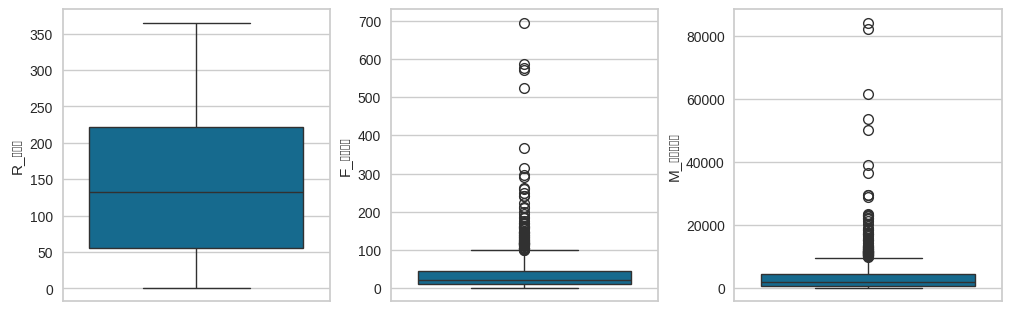

In [18]:
fig,ax = plt.subplots(1,3, figsize = (10,3), constrained_layout = True)
for i,c in enumerate(list(segment.columns)):
    sns.boxplot(y = segment[c], ax = ax[i])
plt.show()

- R_경과일에 비해, F_거래횟수와 M_총거래금액은 이상치가 많이 확인되었다.

In [19]:
segment.describe()

,R_경과일,F_거래횟수,M_총거래금액
count,1468.000000,1468.000000,1468.000000
mean,145.292234,36.051771,3447.718226
std,101.936959,50.885680,5509.811494
min,1.000000,1.000000,1.990000
25%,56.000000,10.000000,707.753180
50%,132.000000,21.000000,1888.053710
75%,221.000000,46.000000,4250.219385
max,365.000000,695.000000,84245.183440


In [20]:
def calculatet_outlier(df,column):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    out = df[column].quantile(0.75) + iqr*1.5
    return out

In [21]:
# R,F,M 구간정의
segment['R'] = pd.qcut(segment['R_경과일'], q = [0, 0.2,0.4, 0.6, 0.8, 1],
                              labels=[5,4,3,2,1]).astype(int)
segment['F'] = pd.cut(segment['F_거래횟수'], bins = [0, 10, 21, 46, calculatet_outlier(segment,'F_거래횟수'), max(segment['F_거래횟수'])],
                              labels=[1,2,3,4,5]).astype(int)
segment['M'] = pd.cut(segment['M_총거래금액'], bins = [0, 707, 1888, 4250, calculatet_outlier(segment,'M_총거래금액'), max(segment['M_총거래금액'])],
                              labels=[1,2,3,4,5]).astype(int)
segment.head()

,R_경과일,F_거래횟수,M_총거래금액,R,F,M
고객ID,,,,,,
USER_0000,108,2,41.64174,3,1,1
USER_0001,60,60,15300.31396,4,4,5
USER_0002,74,23,1565.86594,4,3,2
USER_0003,18,17,1417.62528,5,2,2
USER_0004,108,36,1519.42900,3,3,2


- 이상치가 없는 R값 : 5분위로 나누어서 점수배분
- 이상치가 존재하는 F,M값 : 0 ~ Q1, Q1 ~ Q2, Q2 ~ Q3, Q3 ~ upper_quartile, upper_quartile ~ max 값으로 범위를 나누어서 점수 배분   


In [22]:
features = segment[['R_경과일', 'F_거래횟수', 'M_총거래금액']]

sc= RobustScaler() # F와 M변수에 이상치 다수 존재하기에 이상치에 덜 민감한 Roubst스케일링 사용
scaled_features = pd.DataFrame(sc.fit_transform(features), columns = features.columns)

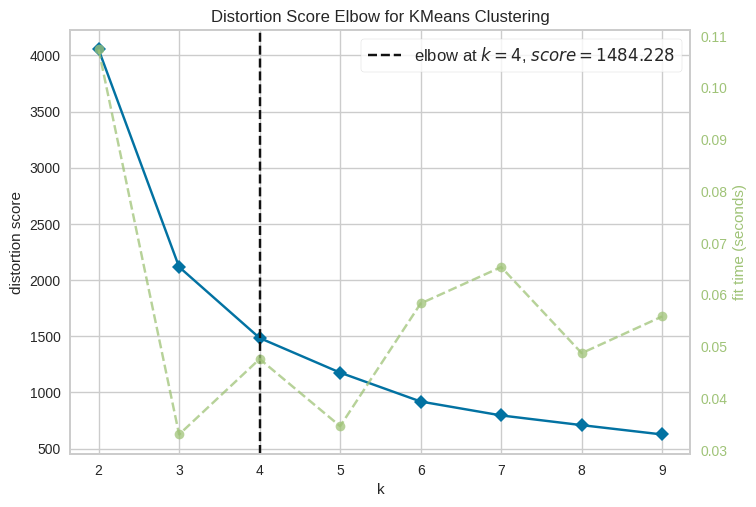

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=42), k=(2, 10))

In [23]:
kelbow_visualizer(KMeans(random_state=42), scaled_features, k=(2,10))

In [24]:
# 엘보우 플롯에 따라 클러스터 그룹은 4로 설정
best_k = 4

kmeans = KMeans(n_clusters = best_k, random_state = 42)
segment['cluster'] = kmeans.fit_predict(scaled_features)
segment.head()

,R_경과일,F_거래횟수,M_총거래금액,R,F,M,cluster
고객ID,,,,,,,
USER_0000,108,2,41.64174,3,1,1,0
USER_0001,60,60,15300.31396,4,4,5,1
USER_0002,74,23,1565.86594,4,3,2,0
USER_0003,18,17,1417.62528,5,2,2,0
USER_0004,108,36,1519.42900,3,3,2,0


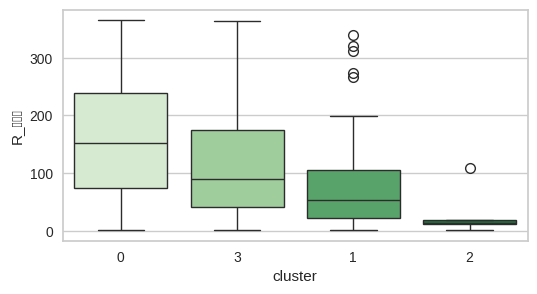

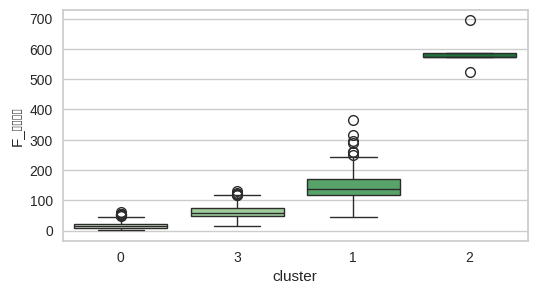

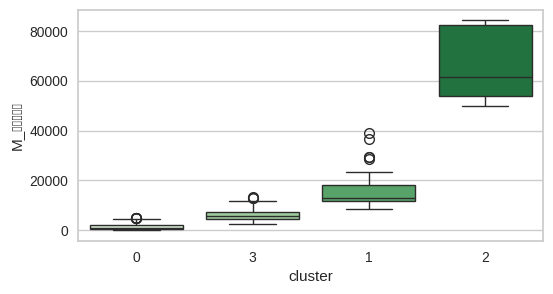

In [25]:
for i,c in enumerate(list(segment.columns[:3])):
    plt.figure(figsize = (6,3))
    sns.boxplot(y = segment[c], x = segment['cluster'], order = [0,3,1,2], palette='Greens')
    plt.show()

- 4개로 나눈 클러스터를 R,F,M으로 나누어서 확인해보니 그룹간의 차이가 확실이 보인다.

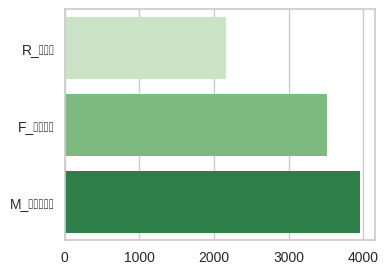

R_경과일: 0.22
F_거래횟수: 0.37
M_총거래금액: 0.41


In [26]:
X = scaled_features
y = segment['cluster']

lgbm = LGBMClassifier(random_state = 42, verbose=-1)
lgbm.fit(X,y)

plt.figure(figsize = (4,3))
sns.barplot(x = lgbm.feature_importances_, y = X.columns, palette='Greens')
plt.ylabel('')
plt.show()

# 가중치 계산
scores = lgbm.feature_importances_ / sum(lgbm.feature_importances_)
for i,c in enumerate(X.columns):
    print(f'{c}: {round(scores[i],2)}')

- LGBClassifier모델을 종속변수를 Cluster설정 후 예측을 함으로써 feature_importance를 확인하였다.(RFM점수에 feature_importance를 기준으로 가중치를 부여해서 고객을 세분화한다.)

In [27]:
# 고객 세분화 (standard, silver, gold, premium 순서)
def customer(RFM_Segment):
    if RFM_Segment <= 20:
        return 'Silver'
    elif RFM_Segment <= 40:
        return 'Silver'
    elif RFM_Segment <= 60:
        return 'Gold'
    elif RFM_Segment <= 80:
        return 'Platinum'
    else:
        return 'Diamond'

# 최종 RFM score 및 고객등급 산출
segment['RFM_score'] = (segment['R']*scores[0] + segment['F']*scores[1] + segment['M']*scores[2])/5*100
segment['고객등급'] = segment['RFM_score'].apply(customer)

In [28]:
segment['고객등급'].value_counts(normalize = True).reindex(['Silver','Gold','Platinum','Diamond'])*100

Silver      34.332425
Gold        28.405995
Platinum    26.702997
Diamond     10.558583
Name: 고객등급, dtype: float64

In [29]:
segment.groupby('고객등급')['M_총거래금액'].sum().sort_values() / segment['M_총거래금액'].sum()*100

고객등급
Silver       5.686369
Gold        16.486064
Platinum    36.288091
Diamond     41.539476
Name: M_총거래금액, dtype: float64

- 높은 등급(Platinum, Diamond)의 고객들은 적은 비중을 차지하지만, 전체 매출에서 큰 부분에 기여하고있다.

In [30]:
# 세그먼트 시각화를 위한 전처리
def RFM_scale(df):
    temp = df.copy()

    # Recency
    temp['R_interval'] = pd.qcut(df['R_경과일'],
                                 q = [0, 0.2,0.4, 0.6, 0.8, 1])
    left = temp['R_interval'].apply(lambda x: x.left).astype(int)
    right =  temp['R_interval'].apply(lambda x: x.right).astype(int)

    df['R_scale'] = (temp['R']-1) + ((temp['R_경과일'] - left-0.01) / (right-left)) - 0.0001

    # Frequency
    temp['F_interval'] = pd.cut(df['F_거래횟수'],
                                bins = [0, 19, 39, 67, calculatet_outlier(df,'F_거래횟수'), max(df['F_거래횟수'])])
    left = temp['F_interval'].apply(lambda x: x.left).astype(int)
    right =  temp['F_interval'].apply(lambda x: x.right).astype(int)

    df['F_scale'] = (temp['F']-1) + ((temp['F_거래횟수'] - left-0.01) / (right-left)) - 0.0001

    # Monetary
    temp['M_interval'] = pd.cut(df['M_총거래금액'],
                                bins = [0, 1692, 3373, 6643, calculatet_outlier(df,'M_총거래금액'), max(df['M_총거래금액'])])
    left = temp['M_interval'].apply(lambda x: x.left).astype(int)
    right =  temp['M_interval'].apply(lambda x: x.right).astype(int)

    df['M_scale'] = (temp['M']-1) + ((temp['M_총거래금액'] - left) / (right-left))-0.0001

    return df

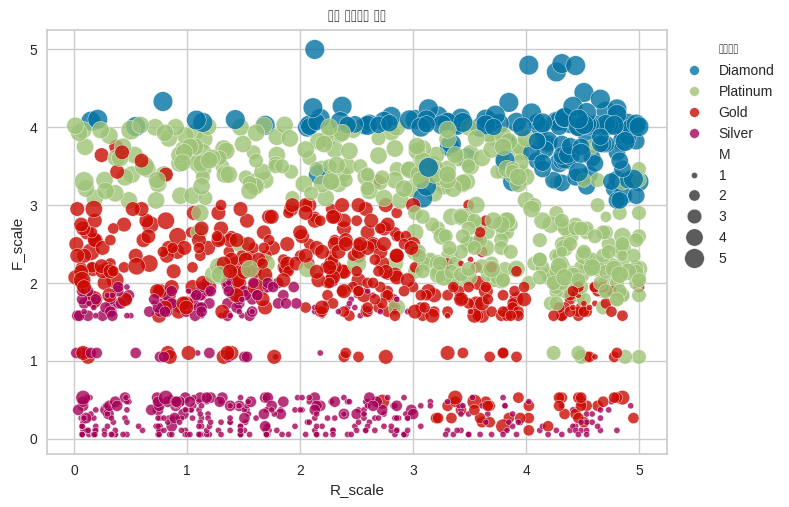

In [31]:
segment= RFM_scale(segment)
sns.scatterplot(x = segment['R_scale'], y = segment['F_scale'], alpha = 0.8
                ,size = segment['M'], sizes = (20,200)
                ,hue = segment['고객등급'], hue_order = ['Diamond','Platinum','Gold','Silver']
               )
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.title('전체 고객등급 분포')
plt.show()

# EDA

In [33]:
# 그래프를 그릴때 순서를 통일하기 위한 order
area_order = ['California', 'Chicago', 'New York', 'New Jersey', 'Washington DC']

category_order = ['Accessories', 'Android', 'Apparel', 'Backpacks', 'Bags',
       'Bottles', 'Drinkware', 'Fun', 'Gift Cards', 'Google', 'Headgear',
       'Housewares', 'Lifestyle', 'More Bags', 'Nest', 'Nest-Canada',
       'Nest-USA', 'Notebooks & Journals', 'Office', 'Waze']

date_order = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]

coupon_order = ['Clicked', 'Used', 'Not Used']

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

grade_order = ["Silver", "Gold", "Platinum", "Diamond"]

season_order = ["봄", "여름", "가을", "겨울"]

In [34]:
# RFM 결과를 dat_raw에 merge 함으로써 고객별 EDA에 고객등급을 이용할 수 있다.

dat_raw = dat_raw.merge(segment, on="고객ID", how="left")
dat_raw.drop(["R_경과일", "F_거래횟수", "M_총거래금액", "RFM_score", "R", "F", "M", "cluster", "R_scale",	"F_scale","M_scale"], axis=1, inplace=True)
dat_raw.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,요일,할인금액,거래금액,계절,최소거래월,최대거래월,고객수명,오프라인비용,온라인비용,고객등급
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5,Diamond
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5,Diamond
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,Tuesday,0.2255,8.5295,겨울,1,1,1,4500,2424.5,Diamond
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,0.65,Not Used,남,...,Tuesday,0.0000,104.0770,겨울,1,1,1,4500,2424.5,Diamond
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,0.65,Used,남,...,Tuesday,1.9470,18.1730,겨울,1,1,1,4500,2424.5,Diamond


In [35]:
# 고객별로 데이터를 분석하기 위한 준비
user_df = dat_raw.groupby("고객ID").agg({"거래금액" : "sum", "거래ID" : "count", "배송료":"sum", "고객지역":"first", "성별":"first", "가입기간":"first",
                                       "제품ID":"nunique", "제품카테고리":"nunique", "할인금액" : "mean", "고객등급":"first"}).rename(columns={"거래금액":"총거래금액", "거래ID":"구매횟수"})
user_df["구매당_평균_배송료"] = user_df["배송료"] / user_df["구매횟수"]
user_df

,총거래금액,구매횟수,배송료,고객지역,성별,가입기간,제품ID,제품카테고리,할인금액,고객등급,구매당_평균_배송료
고객ID,,,,,,,,,,,
USER_0000,41.64174,2,16.66,New York,여,31,2,2,5.353230,Silver,8.330000
USER_0001,15300.31396,60,278.61,New York,남,20,42,10,14.685051,Diamond,4.643500
USER_0002,1565.86594,23,73.46,California,남,39,21,6,6.665863,Gold,3.193913
USER_0003,1417.62528,17,78.07,California,남,25,11,4,9.928172,Gold,4.592353
USER_0004,1519.42900,36,149.49,Chicago,여,31,33,7,6.230300,Gold,4.152500
...,...,...,...,...,...,...,...,...,...,...,...
USER_1463,629.47600,7,47.12,California,여,5,7,4,1.886314,Silver,6.731429
USER_1464,2540.48372,40,156.36,New York,남,43,35,11,6.402422,Platinum,3.909000
USER_1465,120.27750,8,4.87,Chicago,남,25,8,2,0.522363,Silver,0.608750


### 기본분석

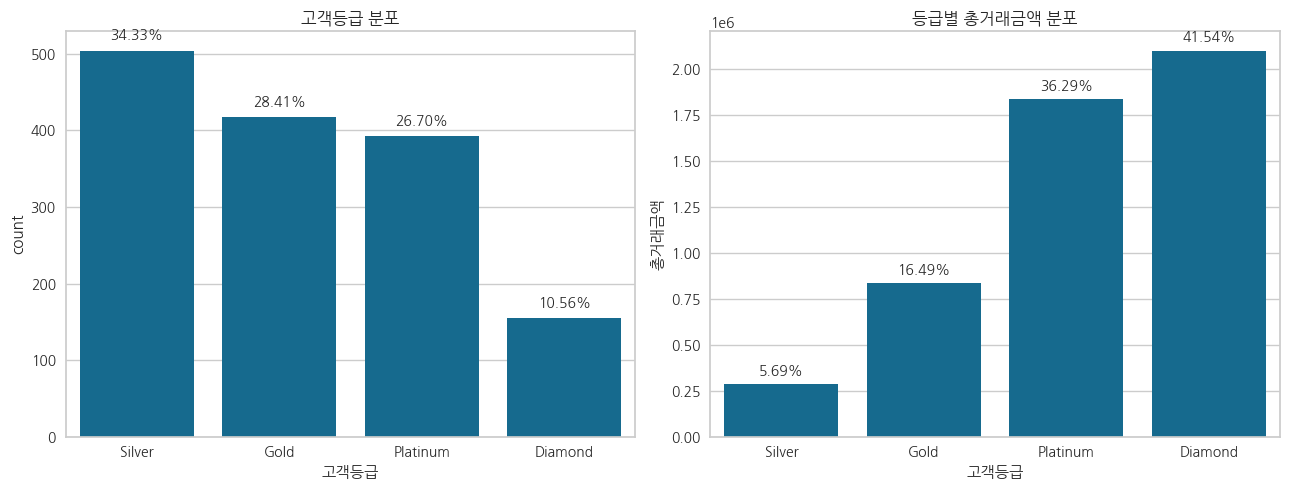

In [36]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title("고객등급 분포")
ax1 = sns.countplot(data=user_df, x="고객등급", order=grade_order)

# 전체 데이터셋의 총 고객 수 계산
total_customers = len(user_df)

# 각 막대의 높이에 대한 비율 계산하여 표시
for p in ax1.patches:
    height = p.get_height()
    percentage = (height / total_customers) * 100
    ax1.text(p.get_x() + p.get_width() / 2., height + total_customers * 0.01, '{:.2f}%'.format(percentage), ha="center")

plt.subplot(1,2,2)
plt.title("등급별 총거래금액 분포")
ax2 = sns.barplot(data=user_df, x="고객등급", y="총거래금액", order=grade_order, estimator=sum, ci=None)

# 전체 데이터셋의 총 거래금액 계산
total_transaction = user_df['총거래금액'].sum()

# 각 막대의 높이에 대한 비율 계산하여 표시
for p in ax2.patches:
    height = p.get_height()
    percentage = (height / total_transaction) * 100
    ax2.text(p.get_x() + p.get_width() / 2., height + total_transaction * 0.01, '{:.2f}%'.format(percentage), ha="center")

plt.tight_layout()
plt.show()

등급이 높은 고객이 중요한 이유

In [37]:
# # 그래프 생성
# bar = sns.barplot(data=user_df, x="고객등급", y="총거래금액", order=grade_order, ci=None)

# # 그래프 위에 값 표시
# for rect in bar.patches:
#     height = rect.get_height()
#     plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.0f(%.0f)$' % (height, height * 0.2), ha='center', va='bottom', size=12)

# # 그래프 출력
# plt.show()

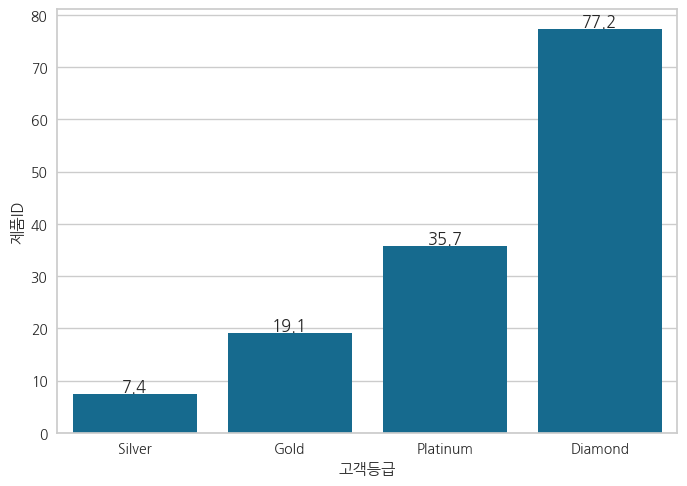

In [38]:
# 그래프 생성
bar = sns.barplot(data=user_df, x="고객등급", y="제품ID", order=grade_order, ci=None)

# 그래프 위에 값 표시
for rect in bar.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size=12)

# 그래프 출력
plt.show()

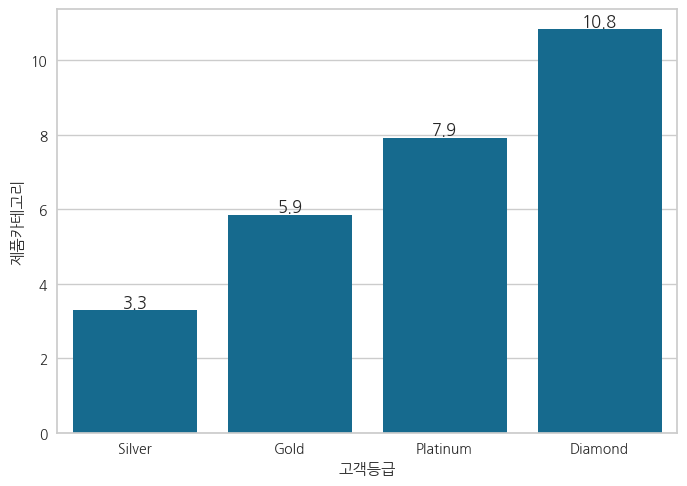

In [39]:
# 그래프 생성
bar = sns.barplot(data=user_df, x="고객등급", y="제품카테고리", order=grade_order, ci=None)

# 그래프 위에 값 표시
for rect in bar.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size=12)

# 그래프 출력
plt.show()

### 할인

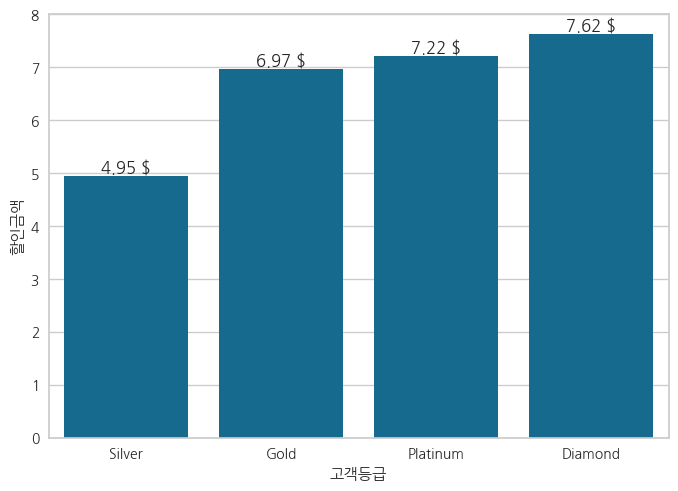

In [40]:
# 그래프 생성
bar = sns.barplot(data=user_df, x="고객등급", y="할인금액", order=grade_order, ci=None)

# 그래프 위에 값 표시
for rect in bar.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f $' % height, ha='center', va='bottom', size=12)

# 그래프 출력
plt.show()

In [92]:
dat_raw.head(3)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,요일,할인금액,거래금액,계절,최소거래월,최대거래월,고객수명,오프라인비용,온라인비용,고객등급
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,...,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5,Diamond
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,...,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5,Diamond
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,남,...,Tuesday,0.2255,8.5295,겨울,1,1,1,4500,2424.5,Diamond


In [109]:
df_dis[["제품카테고리", "할인율", "거래월"]]

,제품카테고리,할인율,거래월
0,Apparel,10,1
1,Apparel,20,2
2,Apparel,30,3
3,Nest-USA,10,1
4,Nest-USA,20,2
...,...,...,...
199,Notebooks & Journals,20,11
200,Notebooks & Journals,30,12
201,Android,10,10
202,Android,20,11


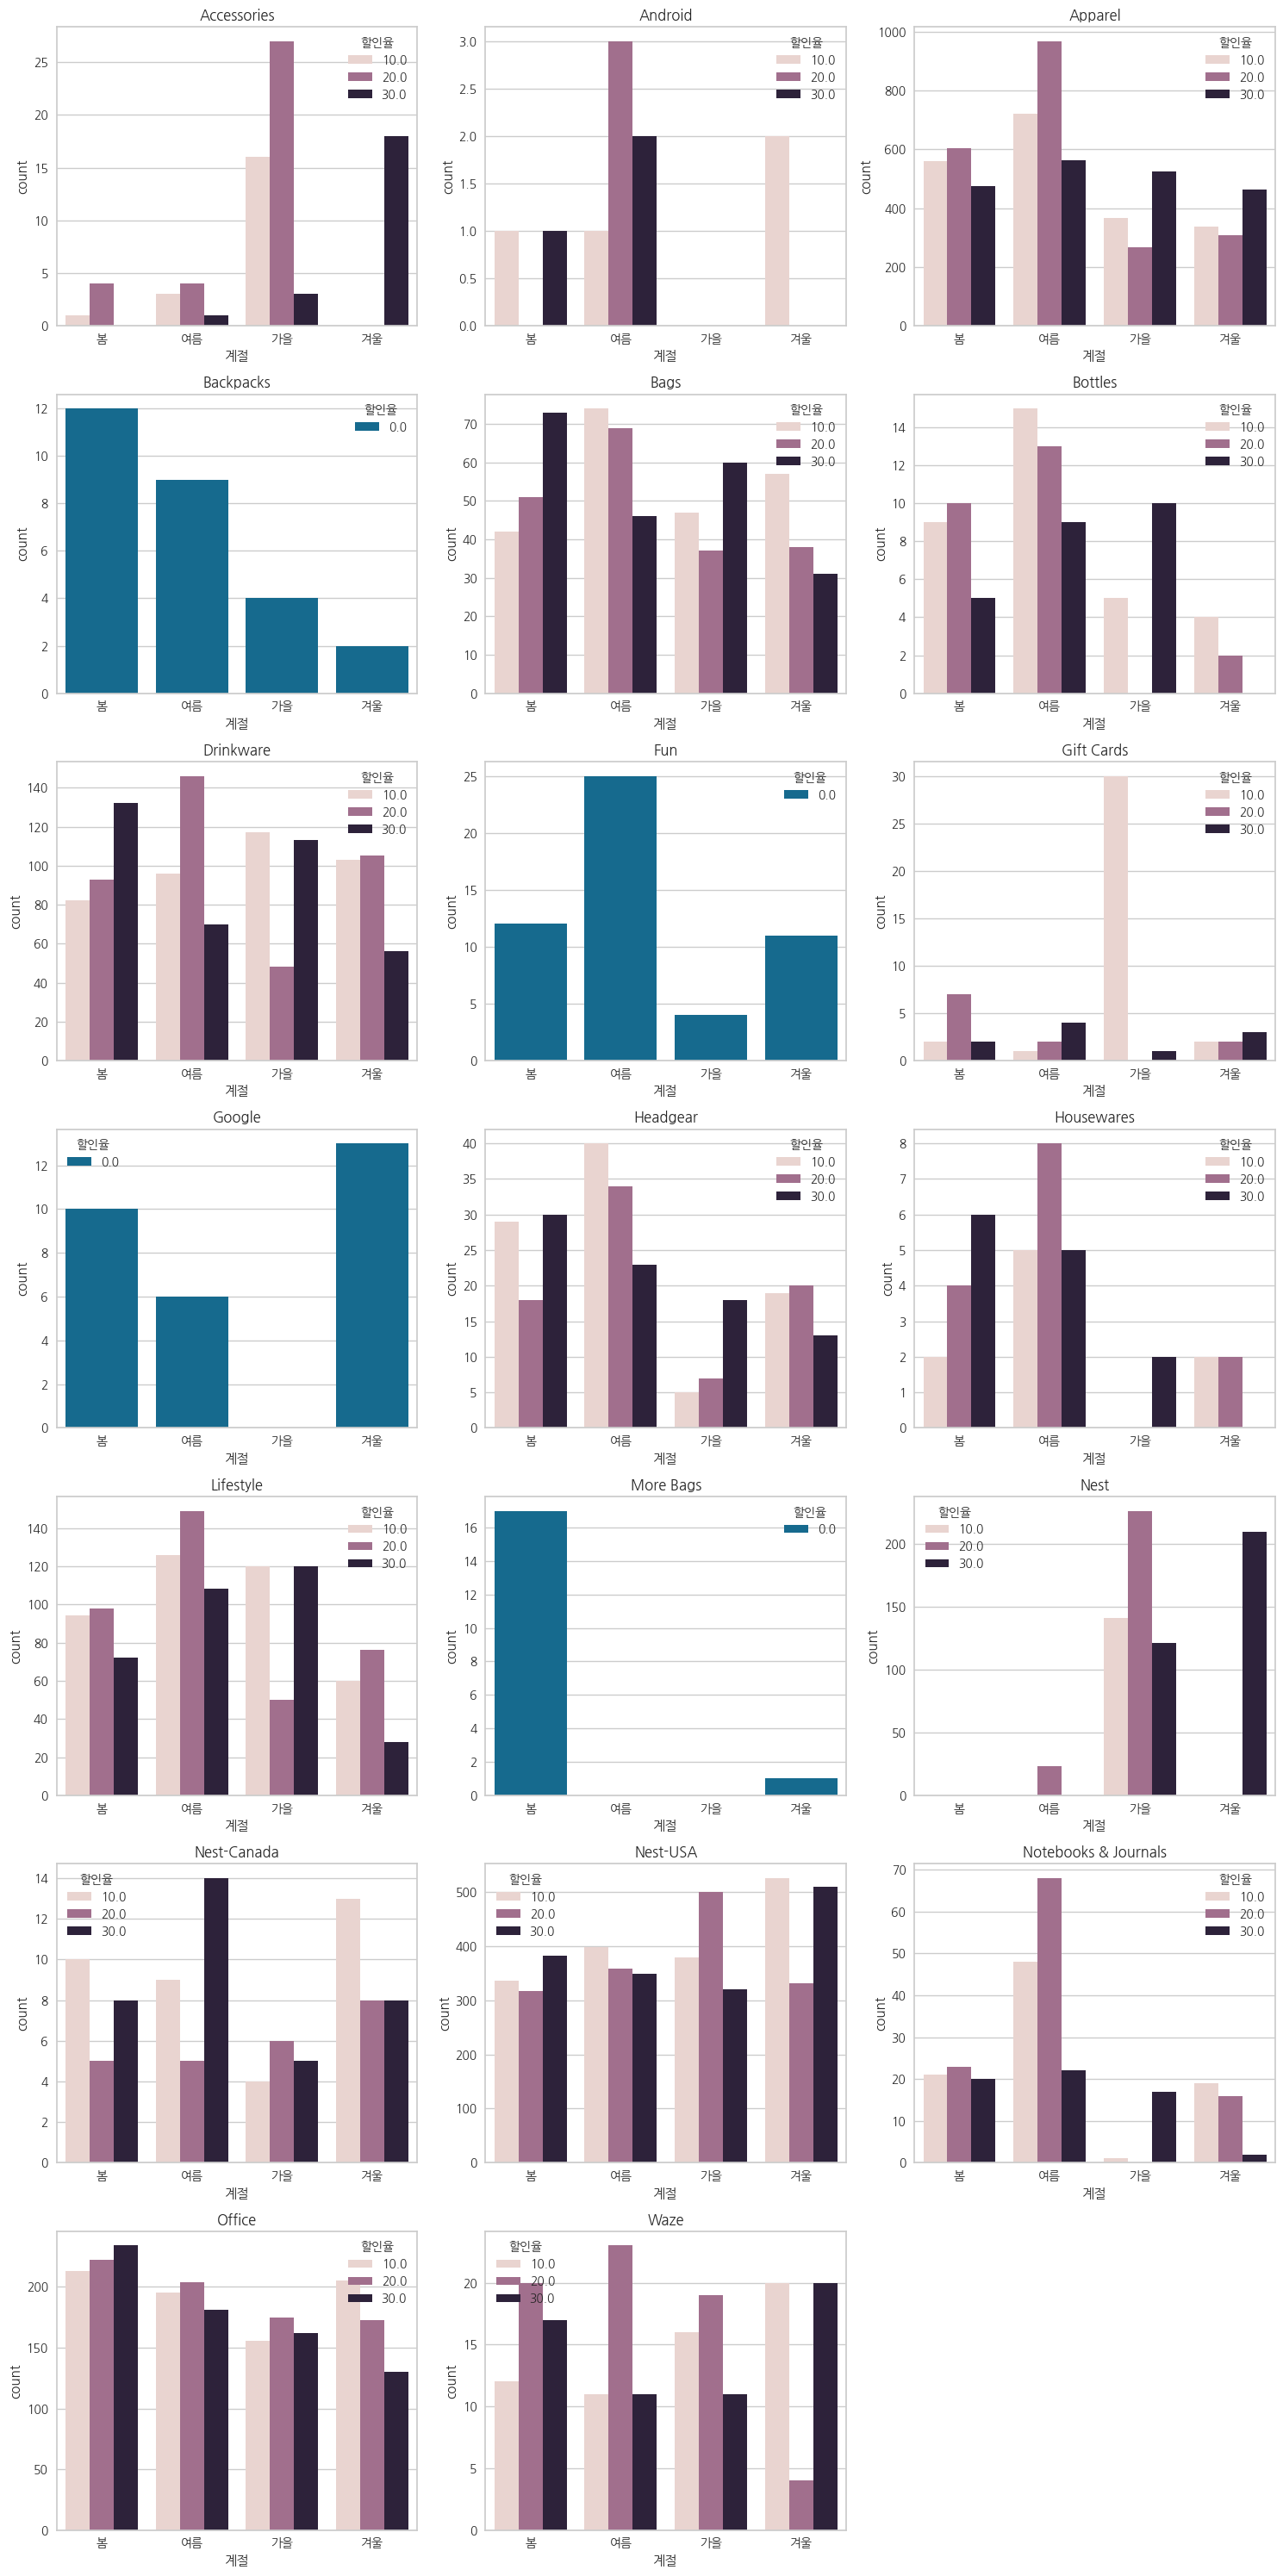

In [107]:
plt.figure(figsize=(15,30))

# 등급별로 그래프 생성
for i, category in enumerate(category_order):
    category_data = dat_raw[(dat_raw['제품카테고리'] == category) & (dat_raw['쿠폰상태'] == "Used")]
    plt.subplot(7,3,1+i)

    #countplot
    sns.countplot(data=category_data, x="계절", hue="할인율", order=season_order)

    plt.title(category)

plt.tight_layout()
plt.show()

### 마케팅

In [59]:
Silver = dat_raw[dat_raw["고객등급"] == "Silver"].copy()
Gold = dat_raw[dat_raw["고객등급"] == "Gold"].copy()
Platinum = dat_raw[dat_raw["고객등급"] == "Platinum"].copy()
Diamond = dat_raw[dat_raw["고객등급"] == "Diamond"].copy()

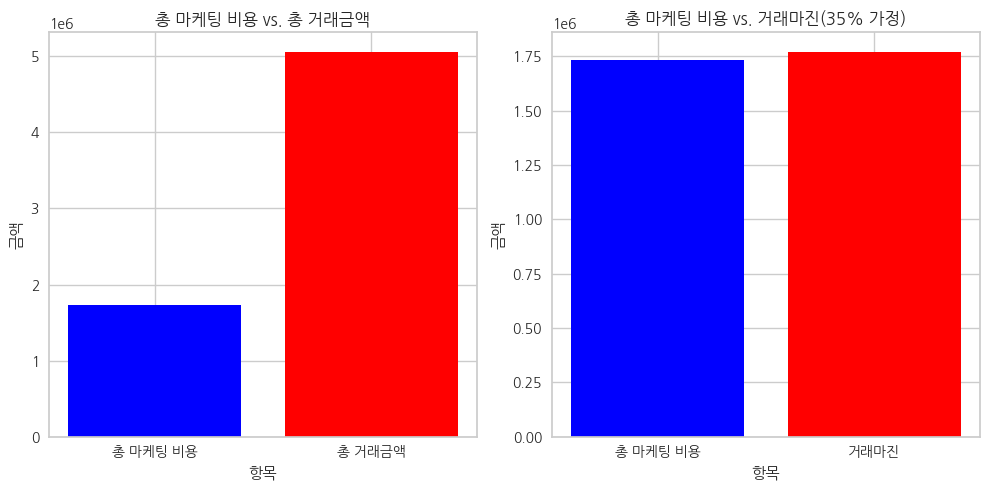

In [81]:
# 데이터 설정
marketing_price = df_mar["오프라인비용"].sum() + df_mar["온라인비용"].sum()
total_price = user_df["총거래금액"].sum()
total_price_margin = user_df["총거래금액"].sum() * 0.35

plt.figure(figsize=(10, 5))

# 막대 그래프 그리기
plt.subplot(1,2,1)
plt.bar(["총 마케팅 비용", "총 거래금액"], [marketing_price, total_price], color=["blue", "red"])
plt.xlabel("항목")
plt.ylabel("금액")
plt.title("총 마케팅 비용 vs. 총 거래금액")

plt.subplot(1,2,2)
plt.bar(["총 마케팅 비용", "거래마진"], [marketing_price, total_price_margin], color=["blue", "red"])
plt.xlabel("항목")
plt.ylabel("금액")
plt.title("총 마케팅 비용 vs. 거래마진(35% 가정)")


plt.tight_layout()
plt.show()

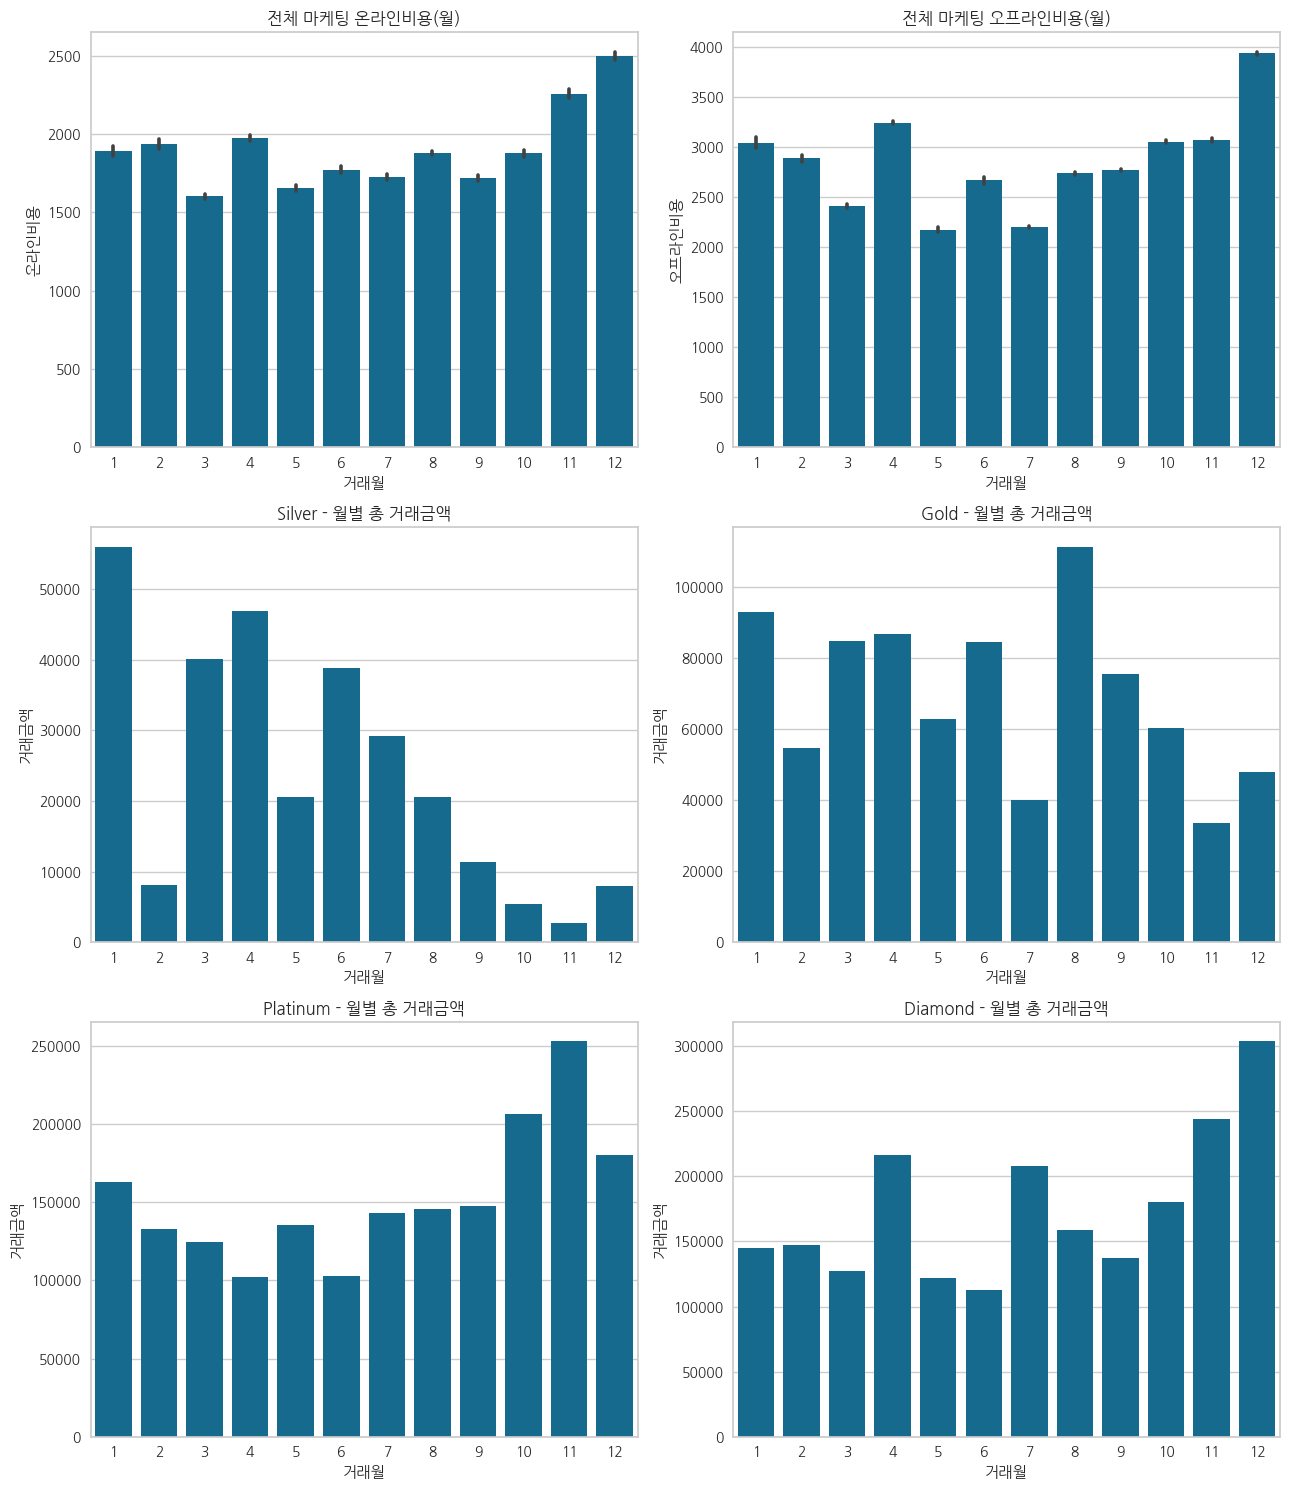

In [60]:
plt.figure(figsize=(13,15))

plt.subplot(3,2,1)
sns.barplot(data=dat_raw, x="거래월", y="온라인비용", order=date_order)
plt.title("전체 마케팅 온라인비용(월)")

plt.subplot(3,2,2)
sns.barplot(data=dat_raw, x="거래월", y="오프라인비용", order=date_order)
plt.title("전체 마케팅 오프라인비용(월)")

plt.subplot(3,2,3)
Silver_day_value = Silver.groupby('거래월')['거래금액'].sum().reset_index()
sns.barplot(data=Silver_day_value, x='거래월', y='거래금액', order=date_order)
plt.title("Silver - 월별 총 거래금액")

plt.subplot(3,2,4)
Gold_day_value = Gold.groupby('거래월')['거래금액'].sum().reset_index()
sns.barplot(data=Gold_day_value, x='거래월', y='거래금액', order=date_order)
plt.title("Gold - 월별 총 거래금액")

plt.subplot(3,2,5)
Platinum_day_value = Platinum.groupby('거래월')['거래금액'].sum().reset_index()
sns.barplot(data=Platinum_day_value, x='거래월', y='거래금액', order=date_order)
plt.title("Platinum - 월별 총 거래금액")

plt.subplot(3,2,6)
Diamond_day_value = Diamond.groupby('거래월')['거래금액'].sum().reset_index()
sns.barplot(data=Diamond_day_value, x='거래월', y='거래금액', order=date_order)
plt.title("Diamond - 월별 총 거래금액")

plt.tight_layout()

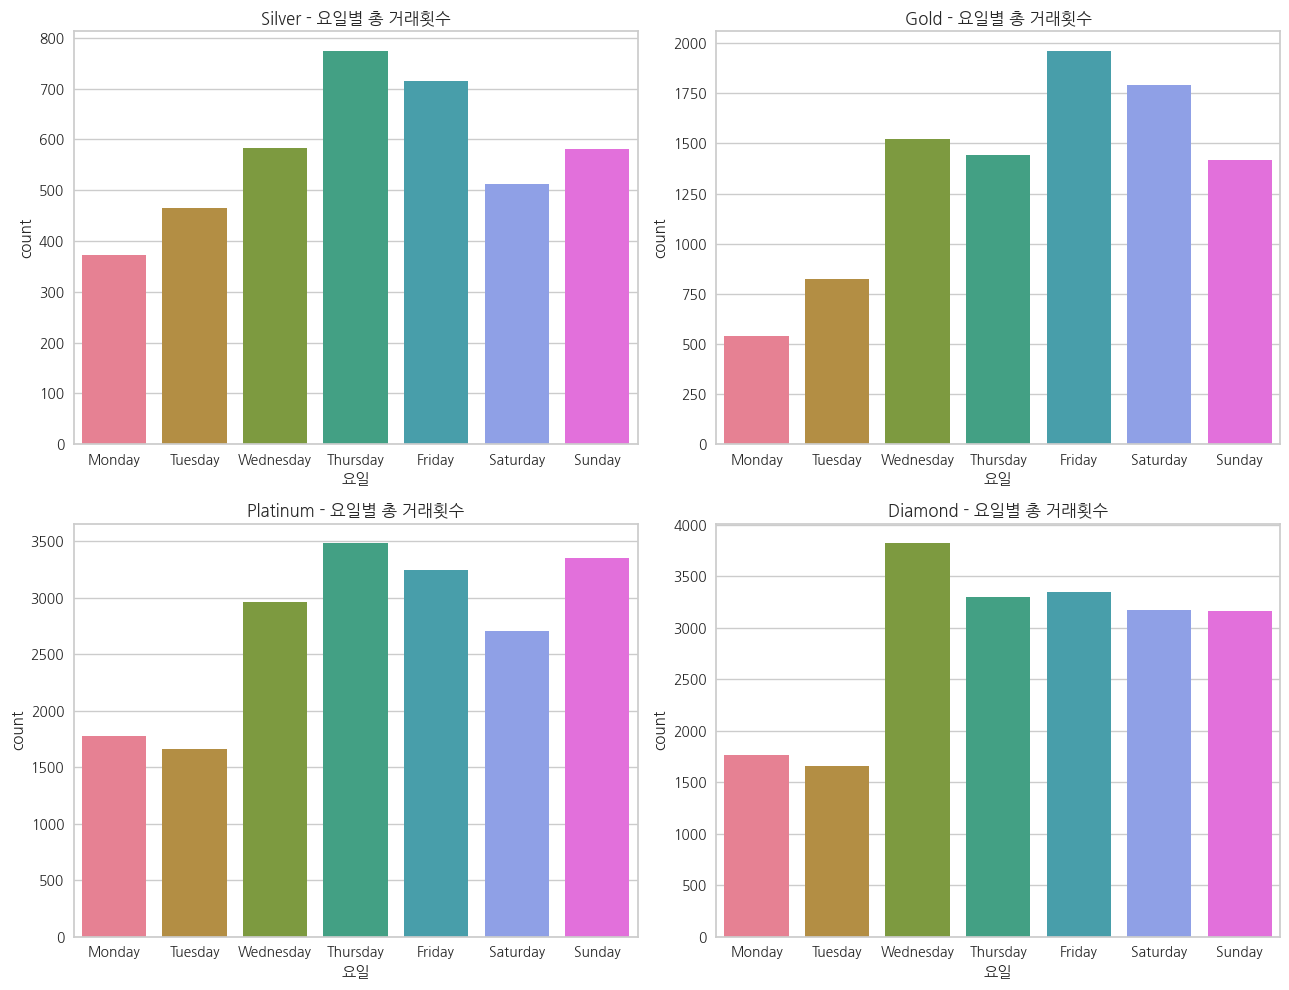

In [72]:
plt.figure(figsize=(13,10))

plt.subplot(2,2,1)
sns.countplot(data=Silver, x='요일', order=day_order, hue="요일", hue_order=day_order)
plt.title("Silver - 요일별 총 거래횟수")

plt.subplot(2,2,2)
sns.countplot(data=Gold, x='요일', order=day_order, hue="요일", hue_order=day_order)
plt.title("Gold - 요일별 총 거래횟수")

plt.subplot(2,2,3)
sns.countplot(data=Platinum, x='요일', order=day_order, hue="요일", hue_order=day_order)
plt.title("Platinum - 요일별 총 거래횟수")

plt.subplot(2,2,4)
sns.countplot(data=Diamond, x='요일', order=day_order, hue="요일", hue_order=day_order)
plt.title("Diamond - 요일별 총 거래횟수")

plt.tight_layout()

###제품

In [43]:
# 같은 제품을 2번 이상 구매한 고객 데이터 추출
duplicate_customers = dat_raw[dat_raw.duplicated(subset=["고객ID", "제품ID"], keep=False)].copy()
duplicate_customers

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,요일,할인금액,거래금액,계절,최소거래월,최대거래월,고객수명,오프라인비용,온라인비용,고객등급
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.50,Diamond
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.50,Diamond
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,Tuesday,0.2255,8.5295,겨울,1,1,1,4500,2424.50,Diamond
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,0.65,Used,남,...,Tuesday,1.9470,18.1730,겨울,1,1,1,4500,2424.50,Diamond
5,USER_1358,Transaction_0003,2019-01-01,Product_0854,Bags,15,5.15,0.65,Used,남,...,Tuesday,9.1155,82.6895,겨울,1,1,1,4500,2424.50,Diamond
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52914,USER_0504,Transaction_25053,2019-12-31,Product_0992,Nest,1,100.91,6.50,Clicked,여,...,Tuesday,0.0000,112.4555,겨울,12,12,1,4000,2058.75,Gold
52915,USER_0504,Transaction_25054,2019-12-31,Product_0976,Nest-USA,1,121.30,2.17,Not Used,여,...,Tuesday,0.0000,135.6000,겨울,12,12,1,4000,2058.75,Gold
52917,USER_0504,Transaction_25054,2019-12-31,Product_0992,Nest,1,100.91,2.17,Clicked,여,...,Tuesday,0.0000,108.1255,겨울,12,12,1,4000,2058.75,Gold
52918,USER_0504,Transaction_25055,2019-12-31,Product_0992,Nest,3,100.91,6.50,Clicked,여,...,Tuesday,0.0000,324.3665,겨울,12,12,1,4000,2058.75,Gold


In [44]:
a = duplicate_customers.groupby("제품ID").agg({"제품카테고리":"first", "계절":"unique", "고객ID":"nunique"})
a

,제품카테고리,계절,고객ID
제품ID,,,
Product_0000,Notebooks & Journals,"[겨울, 여름, 가을]",2
Product_0002,Apparel,"[가을, 겨울]",3
Product_0003,Apparel,"[봄, 가을]",1
Product_0007,Apparel,"[겨울, 가을]",1
Product_0008,Apparel,[여름],1
...,...,...,...
Product_1138,Fun,[겨울],1
Product_1139,Notebooks & Journals,[겨울],1
Product_1141,Notebooks & Journals,"[겨울, 봄, 여름]",2


<Axes: xlabel='count', ylabel='제품카테고리'>

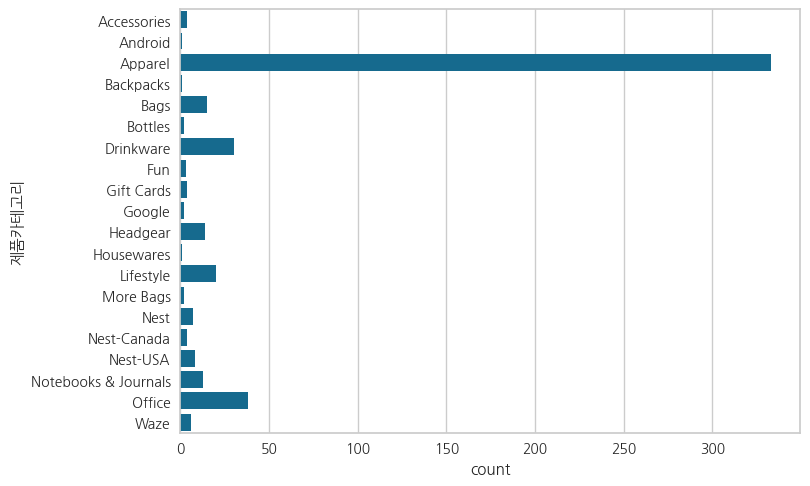

In [45]:
sns.countplot(data=a, y="제품카테고리", order=category_order)

In [46]:
duplicate_customers.groupby("고객ID").agg({"고객등급":"first"})["고객등급"].value_counts()

Platinum    389
Gold        349
Diamond     155
Silver      152
Name: 고객등급, dtype: int64

In [47]:
b = duplicate_customers.groupby("고객ID").agg({"고객등급":"first"})
b

,고객등급
고객ID,
USER_0001,Diamond
USER_0002,Gold
USER_0003,Gold
USER_0004,Gold
USER_0006,Platinum
...,...
USER_1459,Diamond
USER_1460,Diamond
USER_1461,Platinum


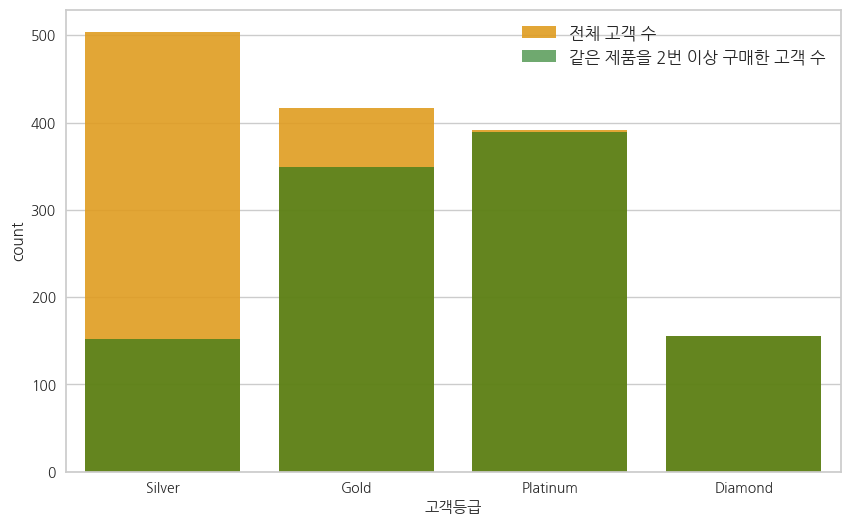

In [48]:
# 두 개의 countplot 겹쳐서 그리기
plt.figure(figsize=(10, 6))

sns.countplot(data=user_df, x="고객등급", order=grade_order, color="orange", alpha=0.9)
sns.countplot(data=b, x="고객등급", order=grade_order, color="green", alpha=0.6)

# 범례 텍스트 설정
plt.legend(["전체 고객 수", "같은 제품을 2번 이상 구매한 고객 수"], fontsize="large")

plt.show()

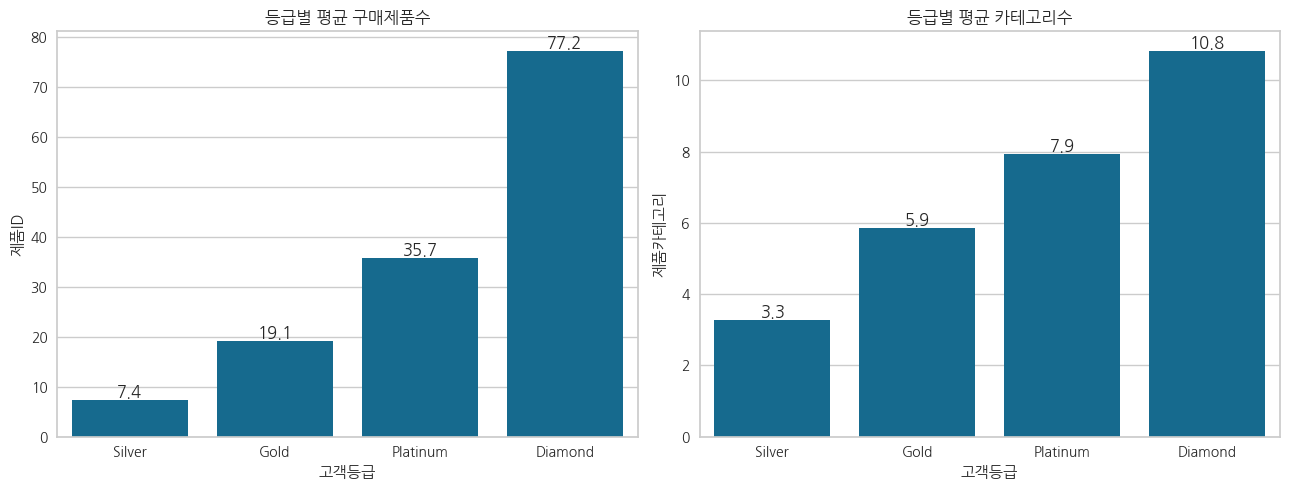

In [49]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
# 그래프 생성
bar1 = sns.barplot(data=user_df, x="고객등급", y="제품ID", order=grade_order, ci=None)
plt.title("등급별 평균 구매제품수")

# 그래프 위에 값 표시
for rect in bar1.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size=12)

plt.subplot(1,2,2)
# 그래프 생성
bar2 = sns.barplot(data=user_df, x="고객등급", y="제품카테고리", order=grade_order, ci=None)
plt.title("등급별 평균 카테고리수")

# 그래프 위에 값 표시
for rect in bar2.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size=12)

plt.tight_layout()

In [51]:
many_products = []
little_products = []

for category in category_order:
  category_df = dat_raw[dat_raw["제품카테고리"] == category]
  if category_df["제품ID"].nunique() > 7:
    many_products.append(category)
  else:
    little_products.append(category)

print(f"품목이 7개 초과인 카테고리 : {many_products}")
print(f"품목이 7개 이하인 카테고리 : {little_products}")

품목이 7개 초과인 카테고리 : ['Apparel', 'Bags', 'Drinkware', 'Headgear', 'Lifestyle', 'Nest', 'Nest-USA', 'Notebooks & Journals', 'Office', 'Waze']
품목이 7개 이하인 카테고리 : ['Accessories', 'Android', 'Backpacks', 'Bottles', 'Fun', 'Gift Cards', 'Google', 'Housewares', 'More Bags', 'Nest-Canada']


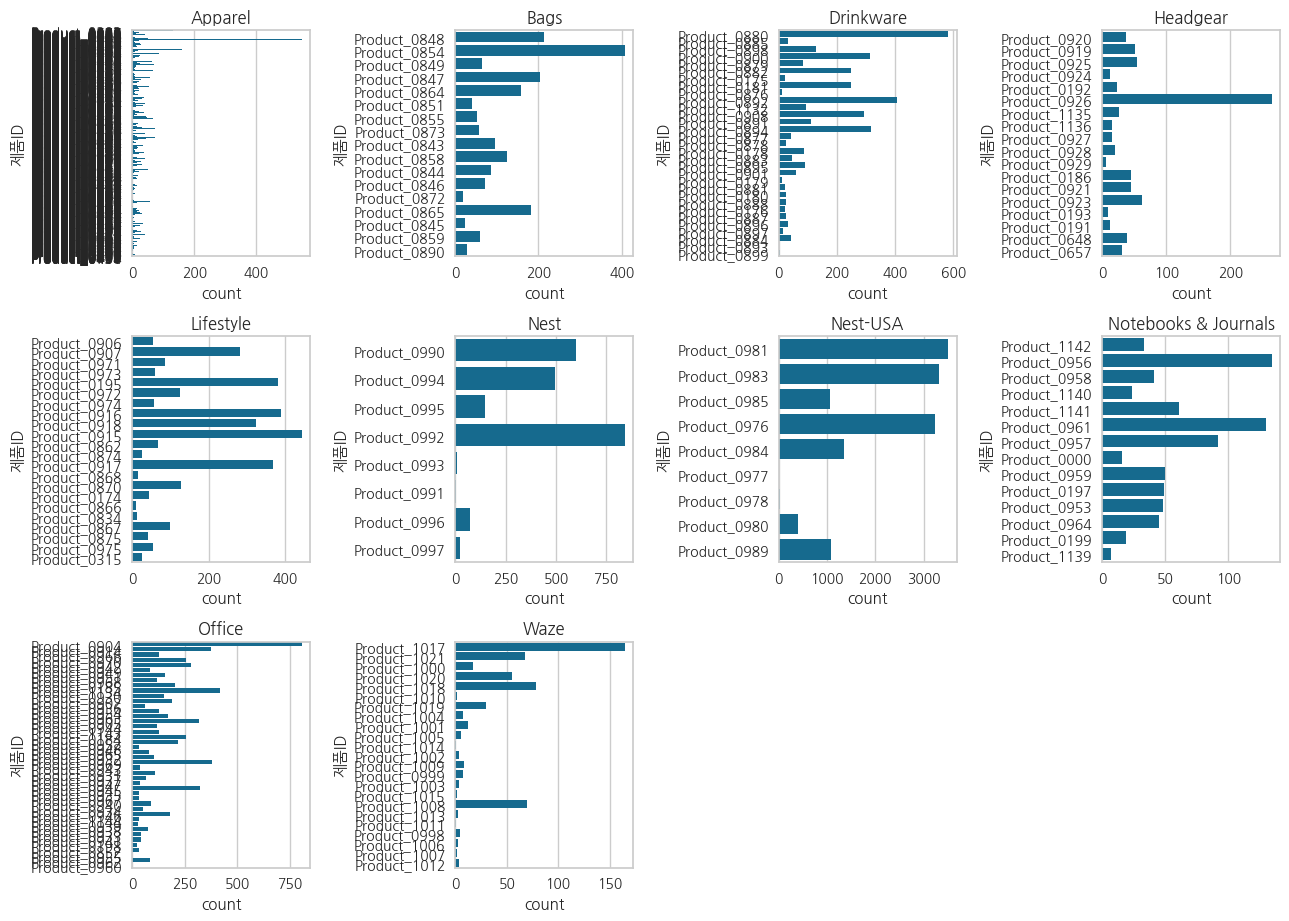

In [52]:
plt.figure(figsize=(13,15))

for i,columns in enumerate(many_products):
  dat = dat_raw[dat_raw["제품카테고리"] == columns]
  plt.subplot(5,4,i+1)
  plt.title(columns)
  sns.countplot(data=dat, y="제품ID")

plt.tight_layout()

In [53]:
# 거래횟수가 가장 많은 순서되로 정렬해서, 그중에 탑3안에 포함되있는 인덱스들을 찾는다.

products_list = []

for category in many_products:
  category_df = dat_raw[dat_raw["제품카테고리"] == category]
  products_index = category_df.groupby("제품ID")["거래ID"].count().sort_values(ascending=False).index[:3]
  products_list.extend(products_index)

In [54]:
# 탑3 제품을 구매한 기록이 있는 고객들로 데이터프레임 생성

user_list2 = dat_raw[dat_raw["제품ID"].isin(products_list)]["고객ID"].unique()

high_user2 = user_df[user_df.index.isin(user_list2)].copy()
not_high_user2 = user_df[~user_df.index.isin(user_list2)].copy()

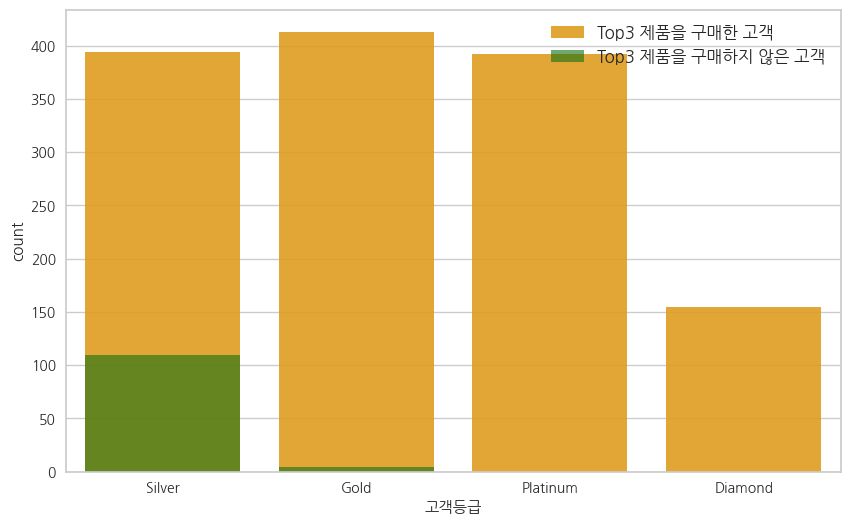

In [56]:
# 두 개의 countplot 겹쳐서 그리기
plt.figure(figsize=(10, 6))

sns.countplot(data=high_user2, x="고객등급", order=grade_order, color="orange", alpha=0.9)
sns.countplot(data=not_high_user2, x="고객등급", order=grade_order, color="green", alpha=0.6)

# 범례 텍스트 설정
plt.legend(["Top3 제품을 구매한 고객", "Top3 제품을 구매하지 않은 고객"], fontsize="large")

plt.show()

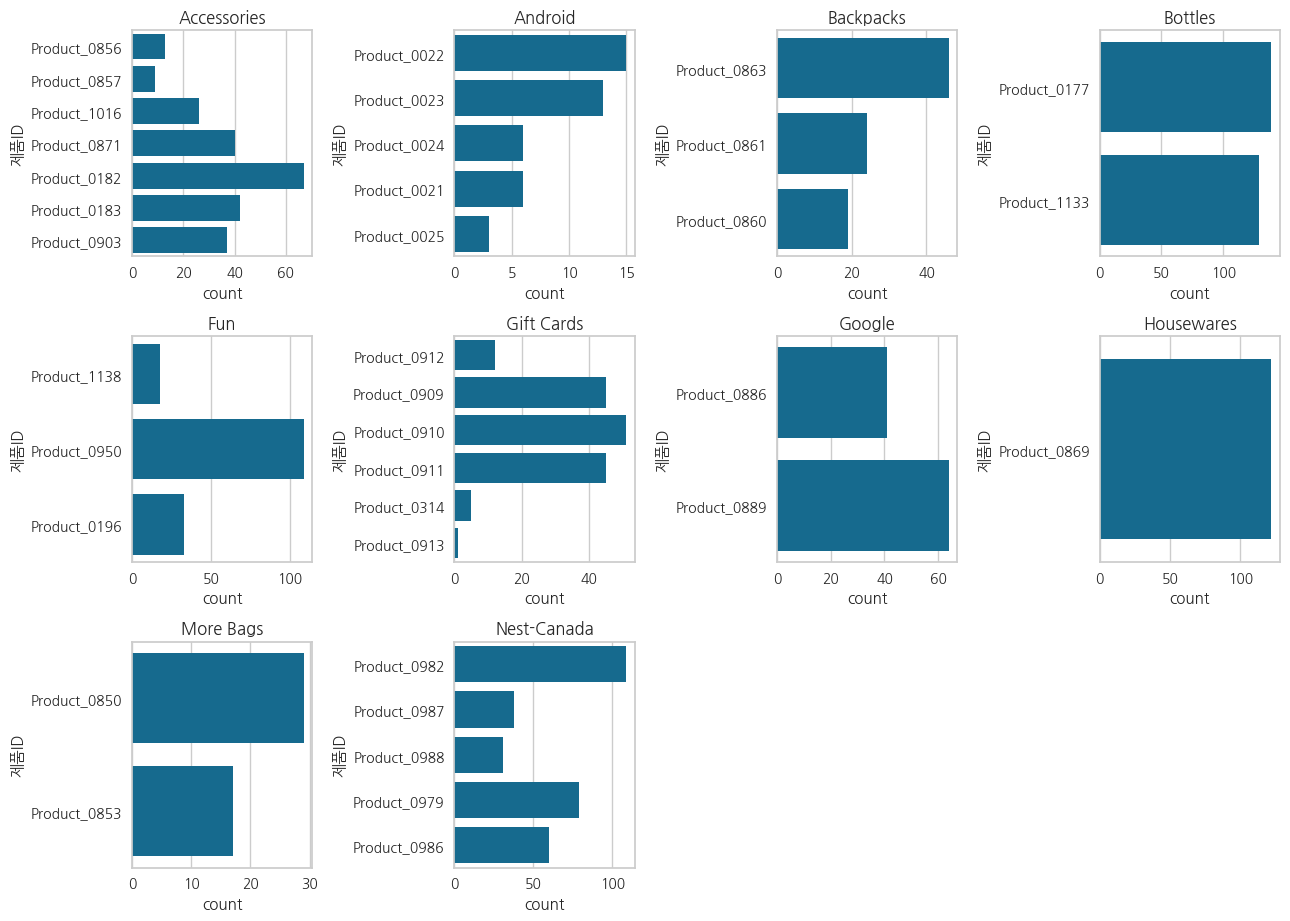

In [57]:
plt.figure(figsize=(13,15))

for i,columns in enumerate(little_products):
  dat = dat_raw[dat_raw["제품카테고리"] == columns]
  plt.subplot(5,4,i+1)
  plt.title(columns)
  sns.countplot(data=dat, y="제품ID")

plt.tight_layout()

### 고객등급에 따른 거래분석(미사용)

- 등급별로 데이터를 나눠서 확인

In [ ]:
# print(f"Silver의 CLV : {clv(Silver)}")
# print(f"Gold의 CLV : {clv(Gold)}")
# print(f"Platinum의 CLV : {clv(Platinum)}")
# print(f"Diamond의 CLV : {clv(Diamond)}")

Silver의 CLV : 1004.12
Gold의 CLV : 4856.35
Platinum의 CLV : 19161.52
Diamond의 CLV : 105375.65


In [ ]:
# category_order = ['Accessories','Android', 'Apparel', 'Bags', 'Bottles', 'Drinkware', 'Fun', 'Gift Cards', 'Google', 'Headgear',
#  'Housewares', 'Lifestyle', 'More Bags', 'Nest', 'Nest-Canada', 'Nest-USA','Notebooks & Journals', 'Office', 'Waze']

In [ ]:
# category = "Apparel"

# Silvers = Silver[Silver["제품카테고리"] == category]
# Golds = Gold[Gold["제품카테고리"] == category]
# Platinums = Platinum[Platinum["제품카테고리"] == category]
# Diamonds = Diamond[Diamond["제품카테고리"] == category]

# plt.figure(figsize=(13,10))

# plt.subplot(2,2,1)
# transaction_count_per_month_s = Silvers.pivot_table(index='거래월', aggfunc='size', fill_value=0)
# transaction_count_per_month_s.plot(kind='line')
# plt.title("Silver")

# plt.subplot(2,2,2)
# transaction_count_per_month_g = Golds.pivot_table(index='거래월', aggfunc='size', fill_value=0)
# transaction_count_per_month_g.plot(kind='line')
# plt.title("Gold")

# plt.subplot(2,2,3)
# transaction_count_per_month_p = Platinums.pivot_table(index='거래월', aggfunc='size', fill_value=0)
# transaction_count_per_month_p.plot(kind='line')
# plt.title("Platinum")

# plt.subplot(2,2,4)
# transaction_count_per_month_d = Diamonds.pivot_table(index='거래월', aggfunc='size', fill_value=0)
# transaction_count_per_month_d.plot(kind='line')
# plt.title("Diamond")

# plt.tight_layout()

### 등급별 월별 거래횟수와 리텐션을 확인한다.(미사용)

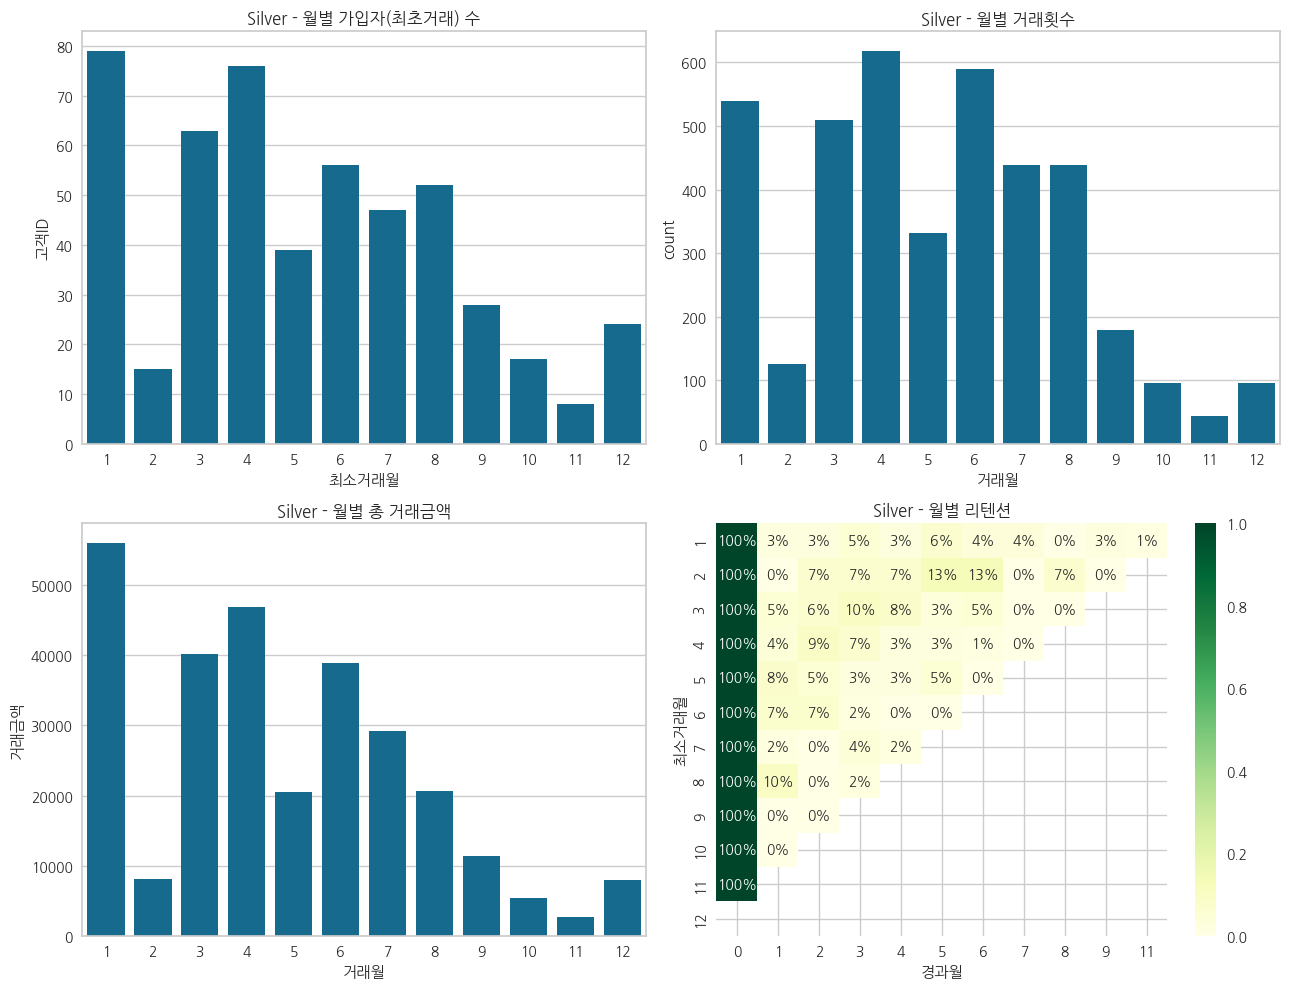

In [ ]:
# plt.figure(figsize=(13,10))

# plt.subplot(2,2,1)
# monthly_count = Silver.groupby('최소거래월')['고객ID'].nunique().reset_index()
# sns.barplot(data=monthly_count, x='최소거래월', y='고객ID')
# plt.title("Silver - 월별 가입자(최초거래) 수")

# plt.subplot(2,2,2)
# sns.countplot(data=Silver, x="거래월", order=date_order)
# plt.title("Silver - 월별 거래횟수")

# plt.subplot(2,2,3)
# monthly_value = Silver.groupby('거래월')['거래금액'].sum().reset_index()
# sns.barplot(data=monthly_value, x='거래월', y='거래금액')
# plt.title("Silver - 월별 총 거래금액")

# plt.subplot(2,2,4)
# plot_retention(Silver)
# plt.title("Silver - 월별 리텐션")

# plt.tight_layout()

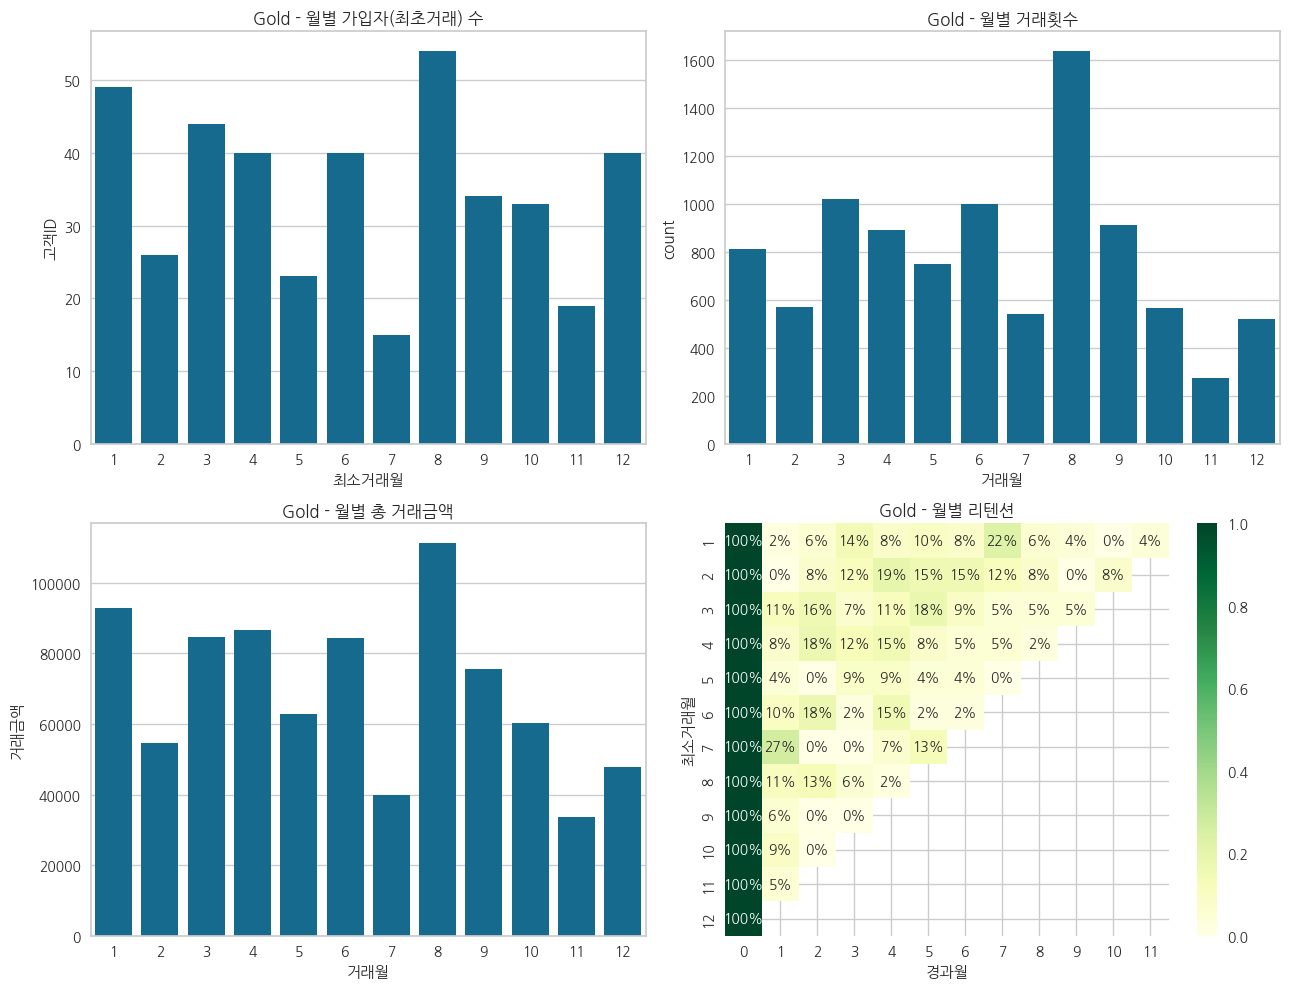

In [ ]:
# plt.figure(figsize=(13,10))

# plt.subplot(2,2,1)
# monthly_count = Gold.groupby('최소거래월')['고객ID'].nunique().reset_index()
# sns.barplot(data=monthly_count, x='최소거래월', y='고객ID')
# plt.title("Gold - 월별 가입자(최초거래) 수")

# plt.subplot(2,2,2)
# sns.countplot(data=Gold, x="거래월", order=date_order)
# plt.title("Gold - 월별 거래횟수")

# plt.subplot(2,2,3)
# monthly_value = Gold.groupby('거래월')['거래금액'].sum().reset_index()
# sns.barplot(data=monthly_value, x='거래월', y='거래금액')
# plt.title("Gold - 월별 총 거래금액")

# plt.subplot(2,2,4)
# plot_retention(Gold)
# plt.title("Gold - 월별 리텐션")

# plt.tight_layout()

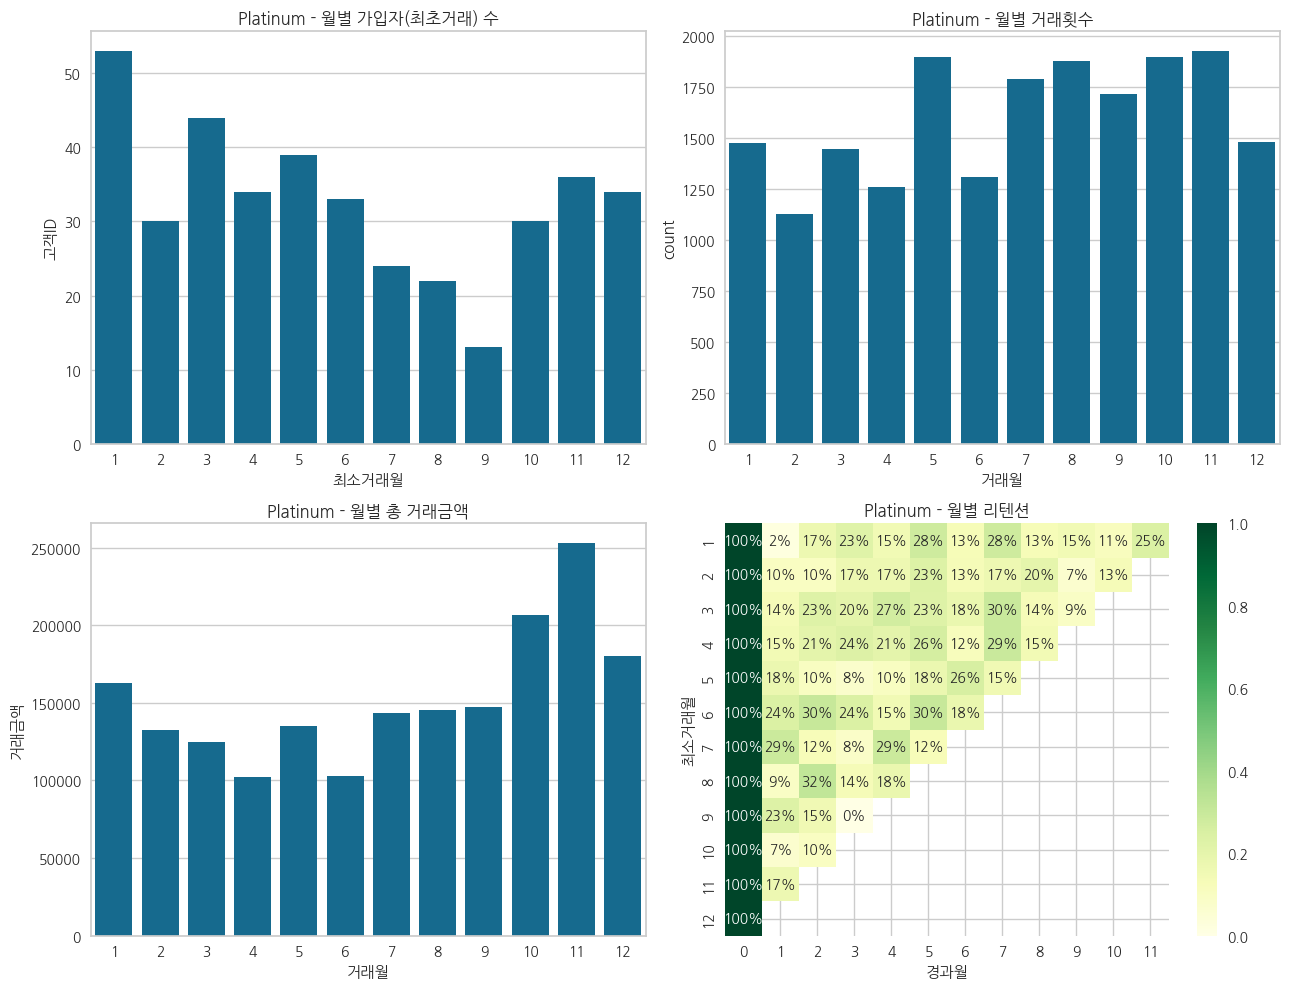

In [ ]:
# plt.figure(figsize=(13,10))

# plt.subplot(2,2,1)
# monthly_count = Platinum.groupby('최소거래월')['고객ID'].nunique().reset_index()
# sns.barplot(data=monthly_count, x='최소거래월', y='고객ID')
# plt.title("Platinum - 월별 가입자(최초거래) 수")

# plt.subplot(2,2,2)
# sns.countplot(data=Platinum, x="거래월", order=date_order)
# plt.title("Platinum - 월별 거래횟수")

# plt.subplot(2,2,3)
# monthly_value = Platinum.groupby('거래월')['거래금액'].sum().reset_index()
# sns.barplot(data=monthly_value, x='거래월', y='거래금액')
# plt.title("Platinum - 월별 총 거래금액")

# plt.subplot(2,2,4)
# plot_retention(Platinum)
# plt.title("Platinum - 월별 리텐션")

# plt.tight_layout()

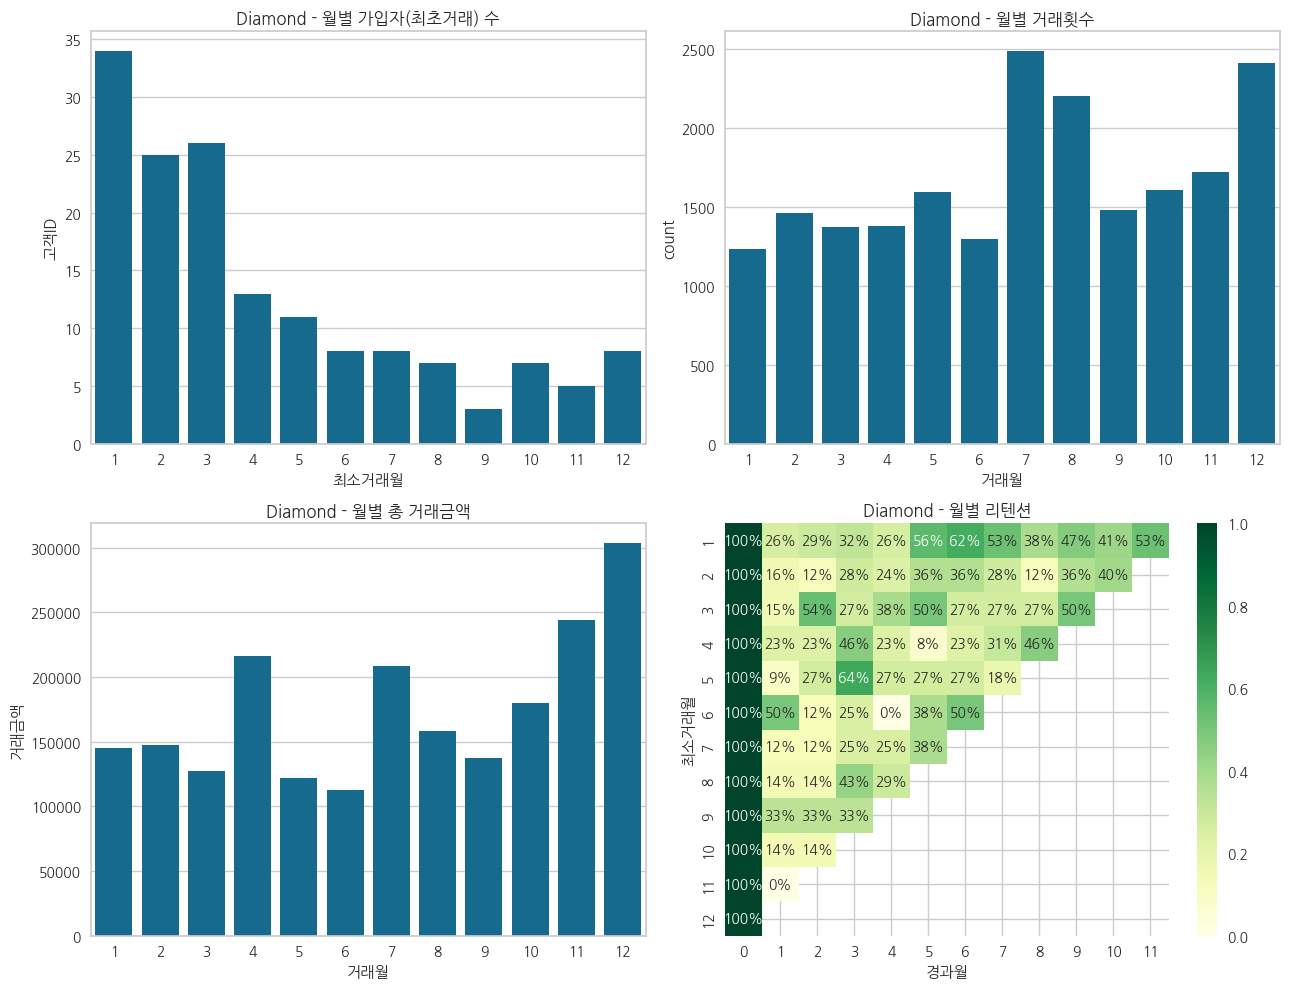

In [ ]:
# plt.figure(figsize=(13,10))

# plt.subplot(2,2,1)
# monthly_count = Diamond.groupby('최소거래월')['고객ID'].nunique().reset_index()
# sns.barplot(data=monthly_count, x='최소거래월', y='고객ID')
# plt.title("Diamond - 월별 가입자(최초거래) 수")

# plt.subplot(2,2,2)
# sns.countplot(data=Diamond, x="거래월", order=date_order)
# plt.title("Diamond - 월별 거래횟수")

# plt.subplot(2,2,3)
# monthly_value = Diamond.groupby('거래월')['거래금액'].sum().reset_index()
# sns.barplot(data=monthly_value, x='거래월', y='거래금액')
# plt.title("Diamond - 월별 총 거래금액")

# plt.subplot(2,2,4)
# plot_retention(Diamond)
# plt.title("Diamond - 월별 리텐션")

# plt.tight_layout()

### 등급별 제품선호도(미사용)

실버

In [ ]:
sns.countplot(Silver, y="제품카테고리", order=category_order)

In [ ]:
category_cross_selling_user(Silver)[:14]

In [ ]:
category_cross_selling_transaction(Silver)[:14]

골드

In [ ]:
sns.countplot(Gold, y="제품카테고리", order=category_order)

In [ ]:
category_cross_selling_user(Gold)[:14]

In [ ]:
category_cross_selling_transaction(Gold)[:14]

플레티넘

In [ ]:
sns.countplot(Platinum, y="제품카테고리", order=category_order)

In [ ]:
category_cross_selling_user(Platinum)[:14]

In [ ]:
product_cross_selling_user(Platinum)[:14]

In [ ]:
category_cross_selling_transaction(Platinum)[:14]

다이아몬드

In [ ]:
sns.countplot(Diamond, y="제품카테고리", order=category_order)

In [ ]:
category_cross_selling_user(Diamond)[:14]

In [ ]:
product_cross_selling_user(Diamond)[:14]

In [ ]:
category_cross_selling_transaction(Diamond)[:14]

일단 다양한 제품과 다양한 카테고리를 추천해주는 것이 등급과 관련이 있다!

결론 :

실버,골드 그룹은 거래와, 고객에 대한 카테고리 연관검색으로, 연관된 카테고리의 top3 제품을 추천해주는 방향

플레티넘,다이아 그룹은 거래와, 고객에 대한 카테고리 연관검색으로 연관된 카테고리의 top3제품을 추천하고, 고객에 대한 상품연관검색도 시행해서 추천해준다.
왜냐하면, 데이터가많고, 재구매율도 높기때문에 상품들에 대한 연관검색도 실행할 수 있다. -> 그리고 유지에 더 도움이 될거같다.

### 쿠폰사용유무에 따른 분석(미사용)

little_products,many_products는 상위제품 구매 고객분석에서 만든 친구들이다.

In [ ]:
little_products_df = dat_raw[(dat_raw["쿠폰상태"] == "Used") & (dat_raw["제품카테고리"].isin(little_products))].copy()
many_products_df = dat_raw[(dat_raw["쿠폰상태"] == "Used") & (dat_raw["제품카테고리"].isin(many_products))].copy()

일단 두 그룹의 쿠폰분포를 확인해봤는데, used, not_used, cliked는 비슷하다..

In [ ]:
little_products_df_low = little_products_df[(little_products_df["고객등급"] == "Silver") | (little_products_df["고객등급"] == "Gold")].copy()
little_products_df_high = little_products_df[(little_products_df["고객등급"] == "Platinum") | (little_products_df["고객등급"] == "Diamond")].copy()

many_products_df_low = many_products_df[(many_products_df["고객등급"] == "Silver") | (many_products_df["고객등급"] == "Gold")].copy()
many_products_df_high = many_products_df[(many_products_df["고객등급"] == "Platinum") | (many_products_df["고객등급"] == "Diamond")].copy()

In [ ]:
little_products_df_low.groupby(["제품카테고리"])["할인율"].value_counts(normalize=True).unstack(fill_value=0) * 100

할인율,0.0,10.0,20.0,30.0
제품카테고리,,,,
Accessories,0.0,28.571429,42.857143,28.571429
Android,0.0,33.333333,33.333333,33.333333
Backpacks,100.0,0.000000,0.000000,0.000000
Bottles,0.0,47.826087,26.086957,26.086957
Fun,100.0,0.000000,0.000000,0.000000
Gift Cards,0.0,62.500000,25.000000,12.500000
Google,100.0,0.000000,0.000000,0.000000
Housewares,0.0,23.076923,30.769231,46.153846
More Bags,100.0,0.000000,0.000000,0.000000


In [ ]:
little_products_df_high.groupby(["제품카테고리"])["할인율"].value_counts(normalize=True).unstack(fill_value=0) * 100

할인율,0.0,10.0,20.0,30.0
제품카테고리,,,,
Accessories,0.0,25.396825,46.031746,28.571429
Android,0.0,42.857143,28.571429,28.571429
Backpacks,100.0,0.000000,0.000000,0.000000
Bottles,0.0,37.288136,32.203390,30.508475
Fun,100.0,0.000000,0.000000,0.000000
Gift Cards,0.0,62.500000,18.750000,18.750000
Google,100.0,0.000000,0.000000,0.000000
Housewares,0.0,26.086957,43.478261,30.434783
More Bags,100.0,0.000000,0.000000,0.000000


둘다 10~20퍼쪽에서 많이 쓴듯

In [ ]:
many_products_df_low.groupby(["제품카테고리"])["할인율"].value_counts(normalize=True).unstack(fill_value=0) * 100

할인율,10.0,20.0,30.0
제품카테고리,,,
Apparel,31.877214,34.769776,33.353011
Bags,31.515152,29.696970,38.787879
Drinkware,33.670034,28.619529,37.710438
Headgear,33.823529,29.411765,36.764706
Lifestyle,32.055749,31.707317,36.236934
Nest,23.157895,26.315789,50.526316
Nest-USA,36.752899,25.869759,37.377342
Notebooks & Journals,23.437500,34.375000,42.187500
Office,33.388158,30.921053,35.690789


In [ ]:
many_products_df_high.groupby(["제품카테고리"])["할인율"].value_counts(normalize=True).unstack(fill_value=0) * 100

할인율,10.0,20.0,30.0
제품카테고리,,,
Apparel,32.384581,34.872255,32.743165
Bags,36.521739,31.739130,31.739130
Drinkware,34.490741,35.532407,29.976852
Headgear,37.234043,31.382979,31.382979
Lifestyle,37.837838,34.643735,27.518428
Nest,19.040000,35.840000,45.120000
Nest-USA,34.252297,33.918129,31.829574
Notebooks & Journals,38.341969,44.041451,17.616580
Office,34.470158,35.688185,29.841657


In [ ]:
# '제품카테고리' 열에 속하는 카테고리가 little_products인지 확인하고, '카테고리수' 열에 'little' 할당
dat_raw.loc[dat_raw["제품카테고리"].isin(little_products), '카테고리수'] = 'little'

# '제품카테고리' 열에 속하는 카테고리가 many_products인지 확인하고, '카테고리수' 열에 'many' 할당
dat_raw.loc[dat_raw["제품카테고리"].isin(many_products), '카테고리수'] = 'many'

In [ ]:
dat_raw.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,할인금액,거래금액,계절,최소거래월,최대거래월,고객수명,오프라인비용,온라인비용,고객등급,카테고리수
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,16.9081,158.6729,겨울,1,1,1,4500,2424.5,Diamond,many
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,16.9081,158.6729,겨울,1,1,1,4500,2424.5,Diamond,many
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,0.2255,8.5295,겨울,1,1,1,4500,2424.5,Diamond,many
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,0.06,Not Used,남,...,0.0000,103.4870,겨울,1,1,1,4500,2424.5,Diamond,many
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,0.06,Used,남,...,1.9470,17.5830,겨울,1,1,1,4500,2424.5,Diamond,many
